# Modelo de clasificación Nivel de Madurez MOTI

**Autor**: Johan David Ramirez Hernandez
           Jonathan Alexander Torres Benitez
           Paula Andrea Escobar López
           Jorge Ivan Gomez
 

### Paquetes

Instalación de paquetes que consideramos relevantes para realizar el ejercicio.

In [87]:
# !pip install boto3
# !pip install shapely
# !pip install hdbscan
# !pip install pycaret
# !pip install scikit-learn
# !pip install pandas
!pip install pivottablejs

Importar librerías necesarias para el desarrollo del modelo

In [88]:
# Operating System
import os
import boto3

# Packages for strings
import re
from unidecode import unidecode

# Packages for data analysis
import numpy as np
import pandas as pd
import shapely
import sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

# Pacakges for Data Science
from sklearn import preprocessing
import hdbscan
import pycaret
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import OPTICS
from pycaret import clustering
from pivottablejs import pivot_ui

# Packages for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Define la fuente alternativa
font_name = "DejaVu Sans"  # Nombre de la fuente alternativa

# Configura la fuente alternativa para Matplotlib
plt.rc('font', family=font_name)

# Funciones 

Función para el reemplzado de outliers (LS - LI)

In [89]:
def replace_outliers(df):
    copy_df = df.copy()
    
    
    columns_to_process = df.columns[1:]

    for column in columns_to_process:
        Q1 = copy_df[column].quantile(0.25)
        Q3 = copy_df[column].quantile(0.75)
        IQR = Q3 - Q1
        whisker_width = 1.5
        lower_whisker = Q1 - (whisker_width * IQR)
        upper_whisker = Q3 + (whisker_width * IQR)
        copy_df.loc[copy_df[column] < lower_whisker, column] = lower_whisker
        copy_df.loc[copy_df[column] > upper_whisker, column] = upper_whisker

    return copy_df

Función para graficas de histogramas y boxplot

In [90]:
def hist_box_plot(df,feature, fig_num):
    sns.set(color_codes = 'Blue', style="whitegrid")
    sns.set_style("whitegrid", {'axes.grid' : False})
    sns.set_context(rc = {'patch.linewidth': 0.0})
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,3))
    filtered = df.loc[~np.isnan(df[feature]), feature]
    sns.boxplot(filtered, ax = ax1, color = 'steelblue') # boxplot
    sns.distplot(filtered, kde=True, hist=True, kde_kws={'linewidth': 1}, color = 'steelblue', ax = ax2) # histogram
    plt.show()

Función para calcular el nivel de benficio cloud

In [91]:
def medicion_beneficio(row, escala, objetivo_lt, objetivo_pt, objetivo_mttr, objetivo_disponibilidad):
    if row['Beneficio Cloud']==0:

        lt = 5*0.20 if (((objetivo_lt*escala)/row['LT'])) > 5 else ((objetivo_lt*escala)/row['LT'])*0.20
        pt = 5*0.2666 if (((objetivo_lt*escala)/row['PT'])) > 5 else ((objetivo_pt*escala)/row['PT'])*0.2666
        mttr = 5*0.2666 if ((objetivo_mttr*escala)/row['mttr_hr']) > 5 else ((objetivo_mttr*escala)/row['mttr_hr'])*0.2666
        disponibilidad = ((row['%Disponibilidad']*escala)/objetivo_disponibilidad)*0.2666
        
    elif row['Beneficio Cloud']==1:
        lt = 5*0.20 if (((objetivo_lt*escala)/row['LT'])) > 5 else ((objetivo_lt*escala)/row['LT'])*0.20
        pt = 5*0.2666 if (((objetivo_pt*escala)/row['PT'])) > 5 else ((objetivo_pt*escala)/row['PT'])*0.2666
        mttr = 5*0.2666 if ((objetivo_mttr*escala)/row['mttr_hr']) > 5 else ((objetivo_mttr*escala)/row['mttr_hr'])*0.2666
        disponibilidad = ((row['%Disponibilidad']*escala)/objetivo_disponibilidad)*0.2666
    elif row['Beneficio Cloud']==2:
        lt = 5*0.20 if (((objetivo_lt*escala)/row['LT'])) > 5 else ((objetivo_lt*escala)/row['LT'])*0.20
        pt = 5*0.2666 if (((objetivo_pt*escala)/row['PT'])) > 5 else ((objetivo_pt*escala)/row['PT'])*0.2666
        mttr = 5*0.2666 if ((objetivo_mttr*escala)/row['mttr_hr']) > 5 else ((objetivo_mttr*escala)/row['mttr_hr'])*0.2666
        disponibilidad = ((row['%Disponibilidad']*escala)/objetivo_disponibilidad)*0.2666
    else:
        lt = 5*0.20 if (((objetivo_lt*escala)/row['LT'])) > 5 else ((objetivo_lt*escala)/row['LT'])*0.20
        pt = 5*0.2666 if (((objetivo_pt*escala)/row['PT'])) > 5 else ((objetivo_pt*escala)/row['PT'])*0.2666
        mttr = 5*0.2666 if ((objetivo_mttr*escala)/row['mttr_hr']) > 5 else ((objetivo_mttr*escala)/row['mttr_hr'])*0.2666
        disponibilidad = ((row['%Disponibilidad']*escala)/objetivo_disponibilidad)*0.2666
    
    row = lt + pt + mttr + disponibilidad
    return row

Función para calcular el nivel de madurez por cod app

In [92]:
def nivel_madurez(x):
    nivel = (((x['Beneficio Cloud']*4) + nivel_cultura + madurez_capacidades)/50)*5
    return round(nivel,1)

# Importar datos

Obtener el datset desde el bucket s3

In [93]:
s3 = boto3.client('s3', region_name='us-east-1')

In [94]:
bucket_name = 'evolucion-modelo-operativo'
key_1 = 'Modelo_analiticio_Medicion_Madurez/df_filtrado_gb_mean.csv'

In [95]:
response = s3.get_object(Bucket=bucket_name, Key=key_1)
df = pd.read_csv(response['Body'])

# Automatización cálculo nivel de madurez por cod app

In [96]:
df.head()

,cod app,"¿Cómo valoras tu satisfacción al usar las capacidades del MO TI en tu día a día; las consideras sencillas, te brindan autonomía y te generan valor?",%Disponibilidad,Min Afectación,Baja,Media,Critica,mttr_hr,Cumple ANS,LT,...,Poco entrenamiento en los temas que implica este cambio,El momento que vive la organización no es pertinente para realizar el cambio,Sentimiento de temor o ansiedad por los cambios que traerá esta transformación,No existe cultura de medición,El cambio no tiene la suficiente credibilidad al momento de generar resultados,El modelo de toma de decisiones para este cambio no es claro,Existen barreras de comunicación en la organización que afectan este cambio,Los objetivos que busca este cambio no están alineados con los objetivos de la organización,Ubicacion Infra,Beneficio Cloud
0,NU0364001,8.0,0.995152,167.166667,0.333333,0.000000,0.333333,67.221898,0.666667,64.646553,...,3,0,0,0,0,0,0,0,3,2
1,AW0450001,8.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.000000,...,3,0,0,0,0,0,0,0,3,3
2,AW1152001,8.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.593719,...,3,0,0,0,0,0,0,0,3,2
3,NU0109001,6.0,0.000000,0.000000,45.000000,3.833333,0.166667,2297.309398,49.000000,57.328434,...,3,0,0,1,1,0,1,0,3,3
4,AW1182001,8.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,99.849337,...,3,0,0,0,0,0,0,0,3,1


In [97]:
df.describe()

,"¿Cómo valoras tu satisfacción al usar las capacidades del MO TI en tu día a día; las consideras sencillas, te brindan autonomía y te generan valor?",%Disponibilidad,Min Afectación,Baja,Media,Critica,mttr_hr,Cumple ANS,LT,PT,...,Poco entrenamiento en los temas que implica este cambio,El momento que vive la organización no es pertinente para realizar el cambio,Sentimiento de temor o ansiedad por los cambios que traerá esta transformación,No existe cultura de medición,El cambio no tiene la suficiente credibilidad al momento de generar resultados,El modelo de toma de decisiones para este cambio no es claro,Existen barreras de comunicación en la organización que afectan este cambio,Los objetivos que busca este cambio no están alineados con los objetivos de la organización,Ubicacion Infra,Beneficio Cloud
count,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,...,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000
mean,8.154450,0.938257,189.139616,7.413613,0.264398,0.147469,349.773701,7.825480,69.904238,31.793635,...,2.937173,0.240838,0.261780,0.272251,0.403141,0.251309,0.387435,0.293194,2.764398,2.136126
std,0.745844,0.220800,304.241550,32.725984,0.809513,0.466646,1310.765469,33.121415,53.420216,50.106637,...,0.301279,0.652612,0.676333,0.570517,0.928944,0.656695,0.862462,0.844740,0.995775,0.963712
min,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.744855,0.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,0.990768,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.050756,10.095732,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000
50%,8.000000,0.997400,54.333333,0.166667,0.000000,0.000000,8.437731,0.333333,54.681547,16.916107,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000
75%,8.750000,1.000000,232.666667,2.750000,0.000000,0.000000,179.849792,3.166667,87.454366,30.428091,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000
max,10.000000,1.000000,1689.833333,391.166667,5.000000,3.666667,14182.766065,393.500000,326.490125,373.365183,...,4.000000,2.000000,2.000000,2.000000,3.000000,4.000000,4.000000,3.000000,4.000000,3.000000


## Cálculo

Definir los valores de cada arista de medición

In [98]:
escala = 5; objetivo_lt = df['LT'].median()
objetivo_pt = df['PT'].median()
objetivo_mttr = df['mttr_hr'].mean()
objetivo_disponibilidad = 99.22
nivel_cultura = 3.067*4; 
madurez_capacidades = 4.015*2

#Prueba
lt = 5*0.20 if ((objetivo_lt*escala)/68) > 5 else ((objetivo_lt*escala)/68)*0.20
print(lt)

0.8041403897058825


Reemplazar los valores de cero con un valor muy cercano a cero para facilitar los cálculos

In [99]:
df.loc[df['mttr_hr'] == 0 , 'mttr_hr'] = 0.00001
df.loc[df['PT'] == 0 , 'PT'] = 0.00001

In [100]:
df.describe()

,"¿Cómo valoras tu satisfacción al usar las capacidades del MO TI en tu día a día; las consideras sencillas, te brindan autonomía y te generan valor?",%Disponibilidad,Min Afectación,Baja,Media,Critica,mttr_hr,Cumple ANS,LT,PT,...,Poco entrenamiento en los temas que implica este cambio,El momento que vive la organización no es pertinente para realizar el cambio,Sentimiento de temor o ansiedad por los cambios que traerá esta transformación,No existe cultura de medición,El cambio no tiene la suficiente credibilidad al momento de generar resultados,El modelo de toma de decisiones para este cambio no es claro,Existen barreras de comunicación en la organización que afectan este cambio,Los objetivos que busca este cambio no están alineados con los objetivos de la organización,Ubicacion Infra,Beneficio Cloud
count,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,...,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000
mean,8.154450,0.938257,189.139616,7.413613,0.264398,0.147469,349.773704,7.825480,69.904238,31.793635,...,2.937173,0.240838,0.261780,0.272251,0.403141,0.251309,0.387435,0.293194,2.764398,2.136126
std,0.745844,0.220800,304.241550,32.725984,0.809513,0.466646,1310.765468,33.121415,53.420216,50.106637,...,0.301279,0.652612,0.676333,0.570517,0.928944,0.656695,0.862462,0.844740,0.995775,0.963712
min,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,7.744855,0.000010,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,0.990768,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,39.050756,10.095732,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000
50%,8.000000,0.997400,54.333333,0.166667,0.000000,0.000000,8.437731,0.333333,54.681547,16.916107,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000
75%,8.750000,1.000000,232.666667,2.750000,0.000000,0.000000,179.849792,3.166667,87.454366,30.428091,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000
max,10.000000,1.000000,1689.833333,391.166667,5.000000,3.666667,14182.766065,393.500000,326.490125,373.365183,...,4.000000,2.000000,2.000000,2.000000,3.000000,4.000000,4.000000,3.000000,4.000000,3.000000


Podemos ver que el reemplazo de los valores cero no tuvo afectación en las estadísticas del dataset

Aplicar función para el cálculo de nivel de beneficion cloud

In [101]:
df['Medición Beneficio Cloud'] = df.apply(lambda x: medicion_beneficio(x, escala, objetivo_lt, objetivo_pt, objetivo_mttr, objetivo_disponibilidad), axis=1)

In [102]:
df.head()

,cod app,"¿Cómo valoras tu satisfacción al usar las capacidades del MO TI en tu día a día; las consideras sencillas, te brindan autonomía y te generan valor?",%Disponibilidad,Min Afectación,Baja,Media,Critica,mttr_hr,Cumple ANS,LT,...,El momento que vive la organización no es pertinente para realizar el cambio,Sentimiento de temor o ansiedad por los cambios que traerá esta transformación,No existe cultura de medición,El cambio no tiene la suficiente credibilidad al momento de generar resultados,El modelo de toma de decisiones para este cambio no es claro,Existen barreras de comunicación en la organización que afectan este cambio,Los objetivos que busca este cambio no están alineados con los objetivos de la organización,Ubicacion Infra,Beneficio Cloud,Medición Beneficio Cloud
0,NU0364001,8.0,0.995152,167.166667,0.333333,0.000000,0.333333,67.221898,0.666667,64.646553,...,0,0,0,0,0,0,0,3,2,3.490919
1,AW0450001,8.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,31.000000,...,0,0,0,0,0,0,0,3,3,3.222131
2,AW1152001,8.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,39.593719,...,0,0,0,0,0,0,0,3,2,3.679435
3,NU0109001,6.0,0.000000,0.000000,45.000000,3.833333,0.166667,2297.309398,49.000000,57.328434,...,0,0,1,1,0,1,0,3,3,2.489784
4,AW1182001,8.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,99.849337,...,0,0,0,0,0,0,0,3,1,2.892218


Calcular la mediana y la media de la arista nivel de benficio cloud, para determinar cual será el meta / objetivo genetal 

In [103]:
print(df['Medición Beneficio Cloud'].mean(), df['Medición Beneficio Cloud'].median())

3.062124200604918 3.1993575338195046


<Axes: >

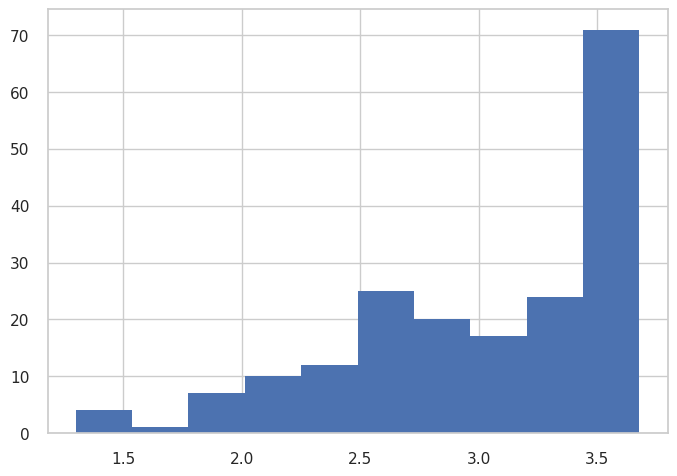

In [104]:
df['Medición Beneficio Cloud'].hist()

<Axes: >

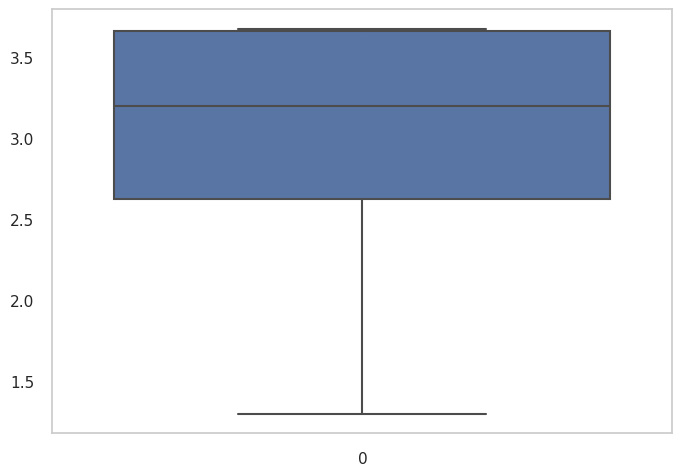

In [105]:
sns.boxplot(df['Medición Beneficio Cloud'])

Crear una nueva variables (periodo de medición) para crear una trazabilidad en el tiempo en la medición del nivel de madurez MOTI

In [106]:
# Para hacer seguimiento de la medición
df['Ciclo de medición'] = '01-2023'

Aplicar función para calcular el nivel de madurez por cod app

In [107]:
df['Nivel Madurez'] = df.apply(lambda x: nivel_madurez(x), axis=1)

In [108]:
df.head()

,cod app,"¿Cómo valoras tu satisfacción al usar las capacidades del MO TI en tu día a día; las consideras sencillas, te brindan autonomía y te generan valor?",%Disponibilidad,Min Afectación,Baja,Media,Critica,mttr_hr,Cumple ANS,LT,...,No existe cultura de medición,El cambio no tiene la suficiente credibilidad al momento de generar resultados,El modelo de toma de decisiones para este cambio no es claro,Existen barreras de comunicación en la organización que afectan este cambio,Los objetivos que busca este cambio no están alineados con los objetivos de la organización,Ubicacion Infra,Beneficio Cloud,Medición Beneficio Cloud,Ciclo de medición,Nivel Madurez
0,NU0364001,8.0,0.995152,167.166667,0.333333,0.000000,0.333333,67.221898,0.666667,64.646553,...,0,0,0,0,0,3,2,3.490919,01-2023,2.8
1,AW0450001,8.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,31.000000,...,0,0,0,0,0,3,3,3.222131,01-2023,3.2
2,AW1152001,8.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,39.593719,...,0,0,0,0,0,3,2,3.679435,01-2023,2.8
3,NU0109001,6.0,0.000000,0.000000,45.000000,3.833333,0.166667,2297.309398,49.000000,57.328434,...,1,1,0,1,0,3,3,2.489784,01-2023,3.2
4,AW1182001,8.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,99.849337,...,0,0,0,0,0,3,1,2.892218,01-2023,2.4


In [109]:
df.describe()

,"¿Cómo valoras tu satisfacción al usar las capacidades del MO TI en tu día a día; las consideras sencillas, te brindan autonomía y te generan valor?",%Disponibilidad,Min Afectación,Baja,Media,Critica,mttr_hr,Cumple ANS,LT,PT,...,Sentimiento de temor o ansiedad por los cambios que traerá esta transformación,No existe cultura de medición,El cambio no tiene la suficiente credibilidad al momento de generar resultados,El modelo de toma de decisiones para este cambio no es claro,Existen barreras de comunicación en la organización que afectan este cambio,Los objetivos que busca este cambio no están alineados con los objetivos de la organización,Ubicacion Infra,Beneficio Cloud,Medición Beneficio Cloud,Nivel Madurez
count,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,...,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000
mean,8.154450,0.938257,189.139616,7.413613,0.264398,0.147469,349.773704,7.825480,69.904238,31.793635,...,0.261780,0.272251,0.403141,0.251309,0.387435,0.293194,2.764398,2.136126,3.062124,2.854450
std,0.745844,0.220800,304.241550,32.725984,0.809513,0.466646,1310.765468,33.121415,53.420216,50.106637,...,0.676333,0.570517,0.928944,0.656695,0.862462,0.844740,0.995775,0.963712,0.594707,0.385485
min,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,7.744855,0.000010,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.298300,2.000000
25%,8.000000,0.990768,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,39.050756,10.095732,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,2.627149,2.800000
50%,8.000000,0.997400,54.333333,0.166667,0.000000,0.000000,8.437731,0.333333,54.681547,16.916107,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,3.199358,2.800000
75%,8.750000,1.000000,232.666667,2.750000,0.000000,0.000000,179.849792,3.166667,87.454366,30.428091,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,3.666000,3.200000
max,10.000000,1.000000,1689.833333,391.166667,5.000000,3.666667,14182.766065,393.500000,326.490125,373.365183,...,2.000000,2.000000,3.000000,4.000000,4.000000,3.000000,4.000000,3.000000,3.679435,3.200000


Cargar dataframe con el calculo de nivel de madurez al s3

In [110]:
csv_filename = 'df_medicion_beneficio.csv'
folder_name = 'Modelo_analiticio_Medicion_Madurez'
df.to_csv(csv_filename)

In [111]:
s3_key = f'{folder_name}/{csv_filename}'

In [112]:
try:
    s3.upload_file(csv_filename, bucket_name, s3_key)
    print(f"{csv_filename} cargado exitosamente en la carpeta {folder_name} en S3.")
except NoCredentialsError:
    print("No se encontraron credenciales de AWS o se han configurado incorrectamente.")

df_medicion_beneficio.csv cargado exitosamente en la carpeta Modelo_analiticio_Medicion_Madurez en S3.


# Carga dataset para ML

In [113]:
key_2 = 'Modelo_analiticio_Medicion_Madurez/df_medicion_beneficio.csv'
response_2 = s3.get_object(Bucket=bucket_name, Key=key_2)
df_medicion_beneficio = pd.read_csv(response_2['Body'])

In [114]:
df = df_medicion_beneficio.copy()

In [115]:
df = df.drop(['Unnamed: 0', 'Ciclo de medición'], axis=1) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 40 columns):
 #   Column                                                                                                                                               Non-Null Count  Dtype  
---  ------                                                                                                                                               --------------  -----  
 0   cod app                                                                                                                                              191 non-null    object 
 1   ¿Cómo valoras tu satisfacción al usar las capacidades del MO TI en tu día a día; las consideras sencillas, te brindan autonomía y te generan valor?  191 non-null    float64
 2   %Disponibilidad                                                                                                                                      191 non-null    float64
 3   

Revisión de el nivel máximo de nivel de madurez por código app

In [116]:
df_sorted = df.sort_values(by='Nivel Madurez', ascending=False)
df_sorted

,cod app,"¿Cómo valoras tu satisfacción al usar las capacidades del MO TI en tu día a día; las consideras sencillas, te brindan autonomía y te generan valor?",%Disponibilidad,Min Afectación,Baja,Media,Critica,mttr_hr,Cumple ANS,LT,...,Sentimiento de temor o ansiedad por los cambios que traerá esta transformación,No existe cultura de medición,El cambio no tiene la suficiente credibilidad al momento de generar resultados,El modelo de toma de decisiones para este cambio no es claro,Existen barreras de comunicación en la organización que afectan este cambio,Los objetivos que busca este cambio no están alineados con los objetivos de la organización,Ubicacion Infra,Beneficio Cloud,Medición Beneficio Cloud,Nivel Madurez
190,AW1221002,8.0,0.993782,267.666667,0.500000,0.000000,0.000000,61.214815,0.500000,76.906954,...,0,2,0,1,1,0,2,3,3.390360,3.2
71,NU0155001,8.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,39.593719,...,0,0,0,0,0,0,0,3,3.666000,3.2
132,NU0027001,8.0,0.994056,266.000000,0.000000,0.000000,0.166667,0.540648,0.166667,193.891960,...,0,0,0,0,0,0,2,3,2.217751,3.2
79,AW1074001,9.0,0.997400,161.333333,2.166667,0.000000,0.000000,34.766250,2.166667,33.796685,...,0,0,0,0,0,0,4,3,3.679400,3.2
78,NU0113001,8.0,0.998051,86.166667,0.166667,0.000000,0.000000,1.772824,0.166667,53.987324,...,0,0,0,0,0,0,3,3,3.679409,3.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,NU0016001,8.0,0.991390,372.833333,0.000000,0.000000,0.000000,0.000010,0.000000,107.993192,...,0,0,0,0,0,0,4,0,3.185662,2.0
50,NU0022004,8.0,0.984720,657.500000,0.166667,0.000000,0.000000,0.070000,0.166667,76.906954,...,0,2,0,1,1,0,4,0,3.390239,2.0
51,NU0022001,8.0,0.984720,657.500000,50.666667,4.166667,1.166667,3265.634259,56.000000,76.906954,...,0,2,0,1,1,0,4,0,2.200013,2.0
70,NU0316001,8.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,39.593719,...,0,0,0,0,0,0,0,0,3.666000,2.0


In [117]:
df_sorted.columns

Index(['cod app',
       '¿Cómo valoras tu satisfacción al usar las capacidades del MO TI en tu día a día; las consideras sencillas, te brindan autonomía y te generan valor?',
       '%Disponibilidad', 'Min Afectación', 'Baja', 'Media', 'Critica',
       'mttr_hr', 'Cumple ANS', 'LT', 'PT', 'Incidentes Onpremise',
       'Incidentes Nube', 'Cambios Onpremise', 'Cambios Nube',
       'Continuidad Onpremise', 'Continuidad Nube', 'Configuración',
       'Habilitar y Mantener Soluciones', 'AMI y Parchado', 'Operaciones TI',
       'Backup & Archiving', 'Optimizar los costos nube',
       'Administrar etiquetas',
       'Administrar estructura de organización y cuentas nube',
       'Nombre del Servicio', 'Nombre de EVC',
       'Falta de tiempo de los líderes',
       'Poco entrenamiento en los temas que implica este cambio',
       'El momento que vive la organización no es pertinente para realizar el cambio',
       'Sentimiento de temor o ansiedad por los cambios que traerá esta transfo

# EDA

## Análisis exploratorio de los datos

Análisis de descriptivo del data set original

In [118]:
df.describe()

,"¿Cómo valoras tu satisfacción al usar las capacidades del MO TI en tu día a día; las consideras sencillas, te brindan autonomía y te generan valor?",%Disponibilidad,Min Afectación,Baja,Media,Critica,mttr_hr,Cumple ANS,LT,PT,...,Sentimiento de temor o ansiedad por los cambios que traerá esta transformación,No existe cultura de medición,El cambio no tiene la suficiente credibilidad al momento de generar resultados,El modelo de toma de decisiones para este cambio no es claro,Existen barreras de comunicación en la organización que afectan este cambio,Los objetivos que busca este cambio no están alineados con los objetivos de la organización,Ubicacion Infra,Beneficio Cloud,Medición Beneficio Cloud,Nivel Madurez
count,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,...,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000
mean,8.154450,0.938257,189.139616,7.413613,0.264398,0.147469,349.773704,7.825480,69.904238,31.793635,...,0.261780,0.272251,0.403141,0.251309,0.387435,0.293194,2.764398,2.136126,3.062124,2.854450
std,0.745844,0.220800,304.241550,32.725984,0.809513,0.466646,1310.765468,33.121415,53.420216,50.106637,...,0.676333,0.570517,0.928944,0.656695,0.862462,0.844740,0.995775,0.963712,0.594707,0.385485
min,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,7.744855,0.000010,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.298300,2.000000
25%,8.000000,0.990768,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,39.050756,10.095732,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,2.627149,2.800000
50%,8.000000,0.997400,54.333333,0.166667,0.000000,0.000000,8.437731,0.333333,54.681547,16.916107,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,3.199358,2.800000
75%,8.750000,1.000000,232.666667,2.750000,0.000000,0.000000,179.849792,3.166667,87.454366,30.428091,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,3.666000,3.200000
max,10.000000,1.000000,1689.833333,391.166667,5.000000,3.666667,14182.766065,393.500000,326.490125,373.365183,...,2.000000,2.000000,3.000000,4.000000,4.000000,3.000000,4.000000,3.000000,3.679435,3.200000


Análisis del nivel de madurez por código app

In [119]:
df_grouped = df.groupby(['Nivel Madurez'])['cod app'].count().sort_values(ascending=False).reset_index()
df_grouped

,Nivel Madurez,cod app
0,3.2,84
1,2.8,68
2,2.4,20
3,2.0,19


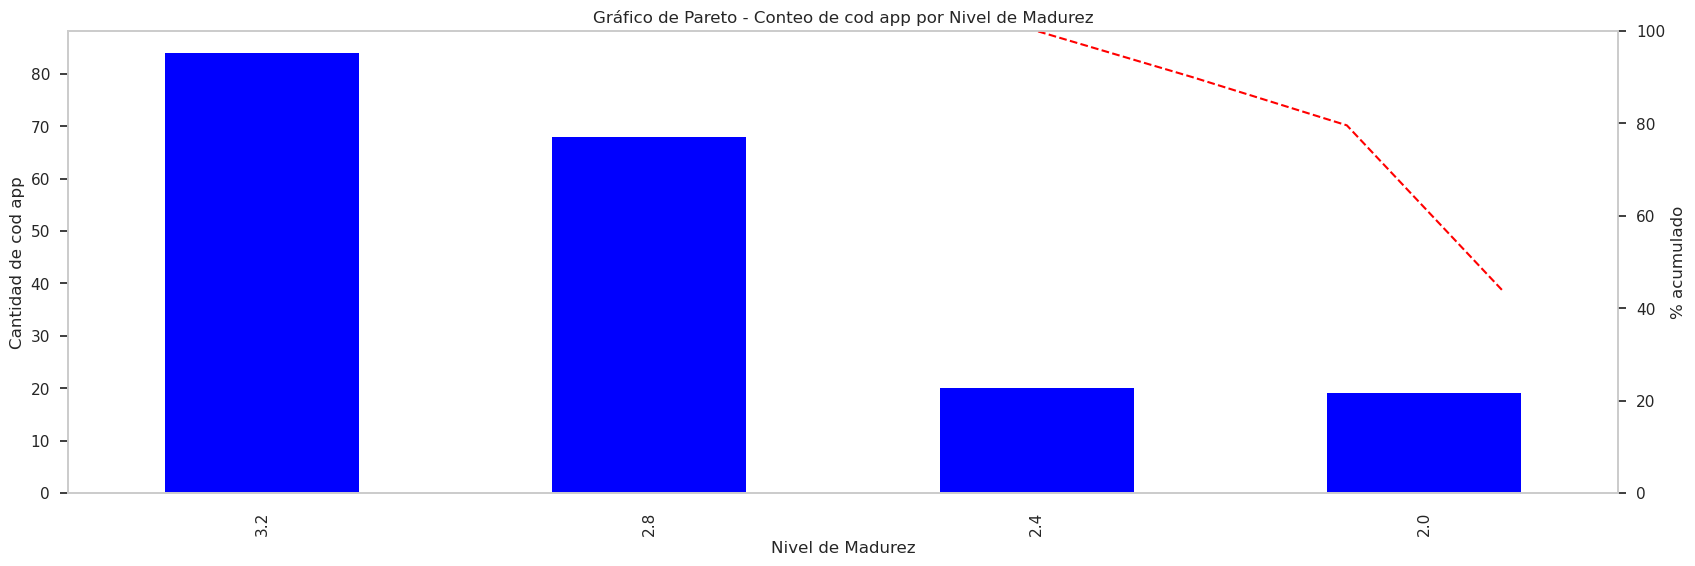

In [120]:
conteo_por_nivel = df['Nivel Madurez'].value_counts().sort_values(ascending=False)

porcentaje_acumulado = conteo_por_nivel.cumsum() / conteo_por_nivel.sum() * 100

plt.figure(figsize=(20, 6))  # Ajusta el tamaño del gráfico según tus preferencias
ax = conteo_por_nivel.plot(kind='bar', color='blue')

plt.xlabel('Nivel de Madurez')
plt.ylabel('Cantidad de cod app')
plt.title('Gráfico de Pareto - Conteo de cod app por Nivel de Madurez')

ax2 = ax.twinx()
ax2.plot(porcentaje_acumulado, linestyle='--', color='red')
ax2.set_ylim([0, 100])
ax2.set_ylabel('% acumulado')
plt.show()

Encontramos que solo el 20% de los cod app tiene un nivel de madurez superior a 2.8 (1-5)

Analizamos la correlación de todas las variables del dataset

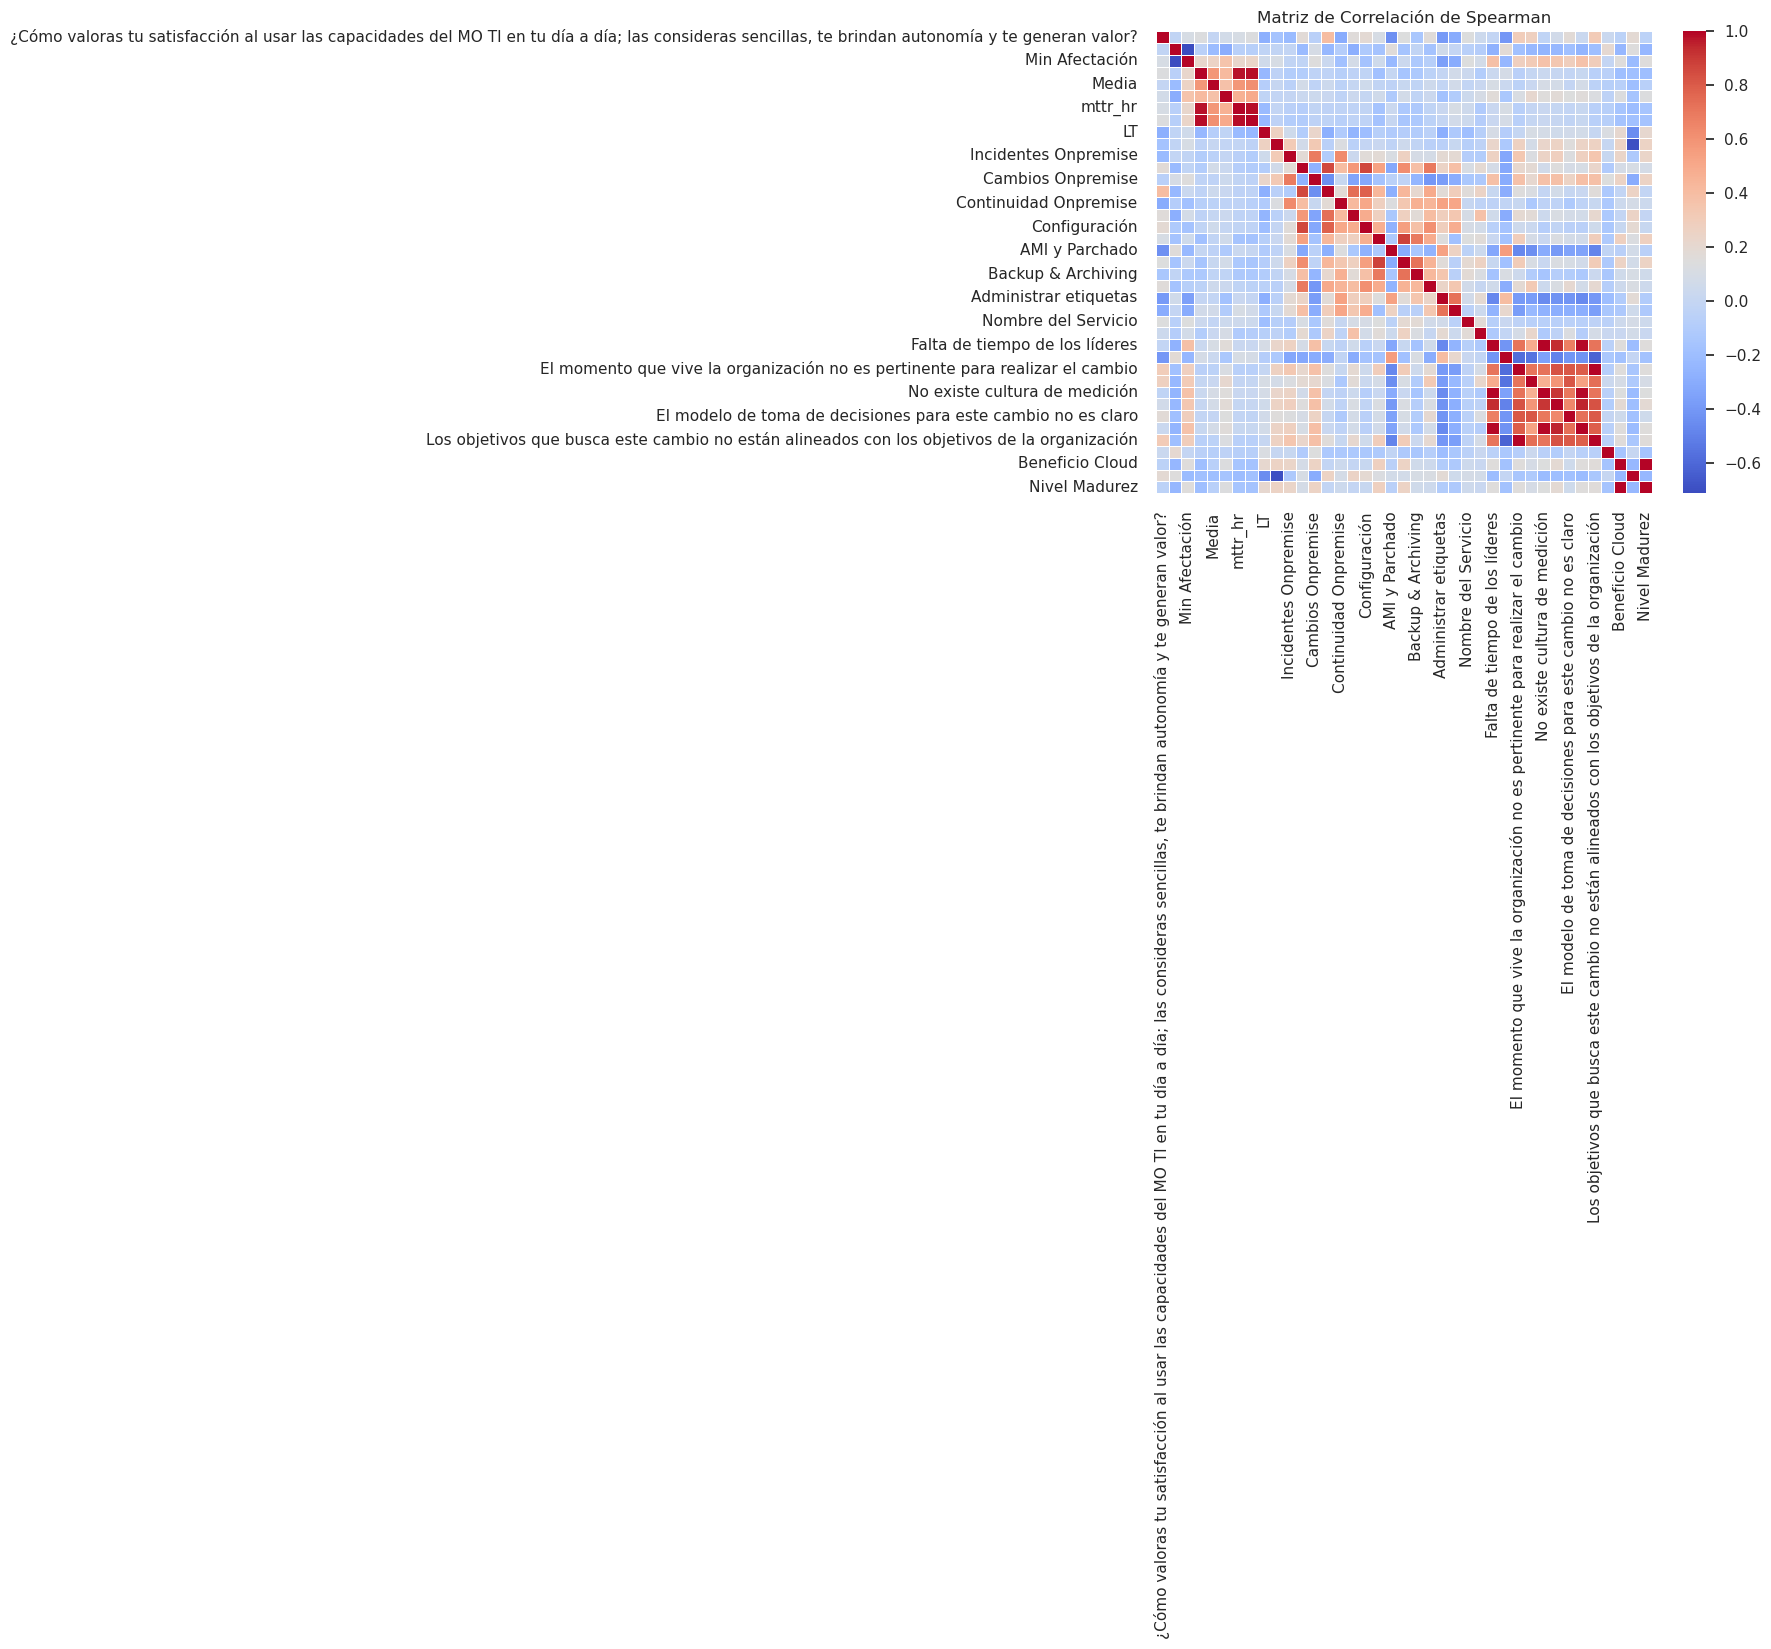

In [121]:
df_grafica = df.drop(columns = 'cod app')

spearman_corr_matrix = df_grafica.corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación de Spearman')
plt.show()

In [122]:
spearman_corr_matrix

,"¿Cómo valoras tu satisfacción al usar las capacidades del MO TI en tu día a día; las consideras sencillas, te brindan autonomía y te generan valor?",%Disponibilidad,Min Afectación,Baja,Media,Critica,mttr_hr,Cumple ANS,LT,PT,...,Sentimiento de temor o ansiedad por los cambios que traerá esta transformación,No existe cultura de medición,El cambio no tiene la suficiente credibilidad al momento de generar resultados,El modelo de toma de decisiones para este cambio no es claro,Existen barreras de comunicación en la organización que afectan este cambio,Los objetivos que busca este cambio no están alineados con los objetivos de la organización,Ubicacion Infra,Beneficio Cloud,Medición Beneficio Cloud,Nivel Madurez
"¿Cómo valoras tu satisfacción al usar las capacidades del MO TI en tu día a día; las consideras sencillas, te brindan autonomía y te generan valor?",1.000000,-0.020604,0.101078,0.134532,-0.005865,0.070796,0.103038,0.131077,-0.282818,-0.168578,...,0.275130,-0.024258,0.063707,0.176818,0.024020,0.316058,0.025930,-0.045233,0.186724,-0.045233
%Disponibilidad,-0.020604,1.000000,-0.712329,-0.063122,-0.212674,-0.293522,-0.063998,-0.075214,-0.025820,-0.022777,...,-0.235839,-0.253118,-0.230978,-0.189560,-0.254162,-0.193963,0.199272,-0.242199,0.145788,-0.242199
Min Afectación,0.101078,-0.712329,1.000000,0.218086,0.255383,0.363677,0.223430,0.236434,0.062645,0.098089,...,0.316931,0.368660,0.338713,0.287481,0.371030,0.293503,-0.007206,0.153765,-0.213809,0.153765
Baja,0.134532,-0.063122,0.218086,1.000000,0.580986,0.415199,0.976391,0.984767,-0.235665,-0.039509,...,0.002338,0.026493,0.006149,-0.012891,0.015523,-0.063621,-0.057368,-0.195493,-0.187574,-0.195493
Media,-0.005865,-0.212674,0.255383,0.580986,1.000000,0.372867,0.579639,0.613111,-0.082026,0.009075,...,0.023361,0.092149,0.078782,-0.006786,0.080500,-0.044751,-0.071732,-0.067966,-0.194119,-0.067966
Critica,0.070796,-0.293522,0.363677,0.415199,0.372867,1.000000,0.458867,0.495635,-0.026730,-0.011412,...,0.205961,0.153594,0.171522,0.141504,0.160381,0.124516,-0.042731,0.131288,-0.163407,0.131288
mttr_hr,0.103038,-0.063998,0.223430,0.976391,0.579639,0.458867,1.000000,0.980947,-0.220885,-0.011493,...,-0.004938,0.021697,0.000439,-0.014470,0.010320,-0.068230,-0.076268,-0.155944,-0.209819,-0.155944
Cumple ANS,0.131077,-0.075214,0.236434,0.984767,0.613111,0.495635,0.980947,1.000000,-0.233343,-0.041649,...,0.001017,0.020788,0.004608,-0.021297,0.010674,-0.066396,-0.076488,-0.170243,-0.178733,-0.170243
LT,-0.282818,-0.025820,0.062645,-0.235665,-0.082026,-0.026730,-0.220885,-0.233343,1.000000,0.268965,...,0.100615,0.083820,0.059156,0.065840,0.076251,0.009674,0.122611,0.205768,-0.450891,0.205768
PT,-0.168578,-0.022777,0.098089,-0.039509,0.009075,-0.011412,-0.011493,-0.041649,0.268965,1.000000,...,0.080693,0.230458,0.256397,0.156804,0.245667,0.263420,0.006997,0.256869,-0.697209,0.256869


Podemos observar que las variables que componene la arista de benficio cloud son las que mayor correlación tienen, estás serán tenidas en cuenta en el modelo

In [123]:
columnas = ['¿Cómo valoras tu satisfacción al usar las capacidades del MO TI en tu día a día; las consideras sencillas, te brindan autonomía y te generan valor?',
       '%Disponibilidad', 'Min Afectación', 'Baja', 'Media', 'Critica',
       'mttr_hr', 'Cumple ANS','Medición Beneficio Cloud','Nivel Madurez']

Analizamos la distribución de las variables númericas

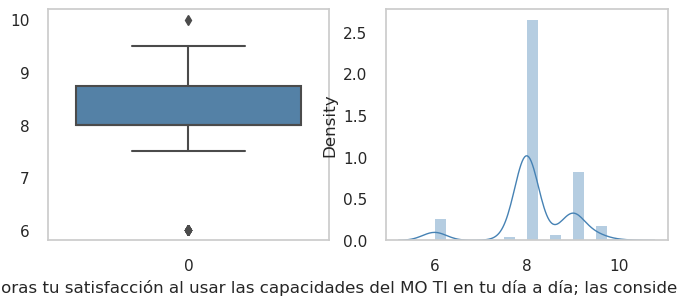

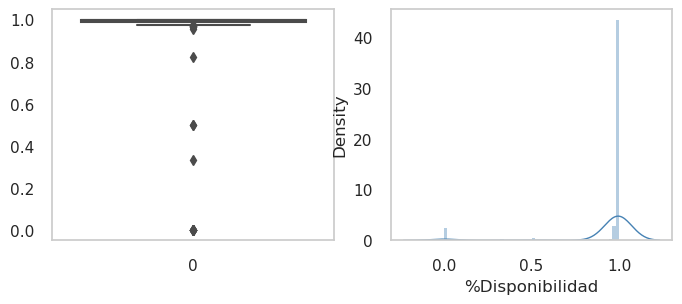

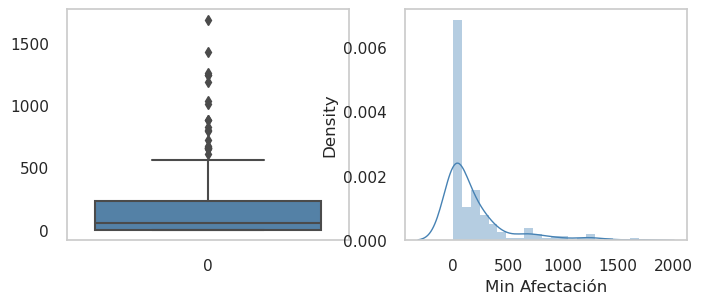

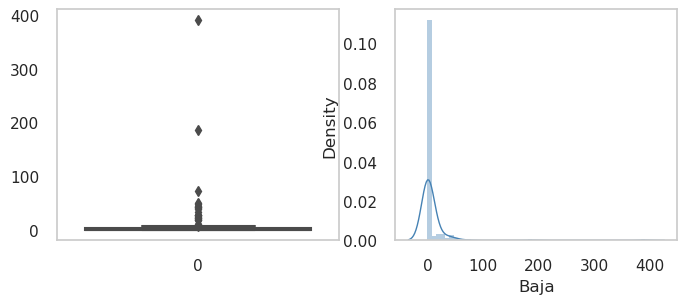

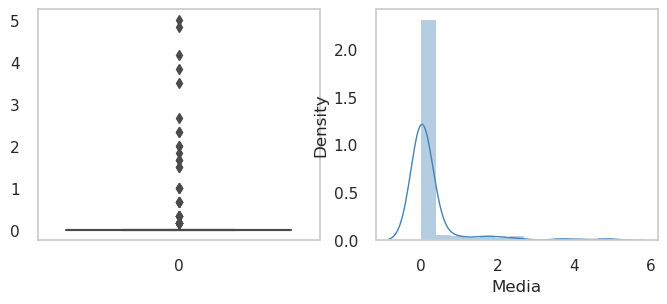

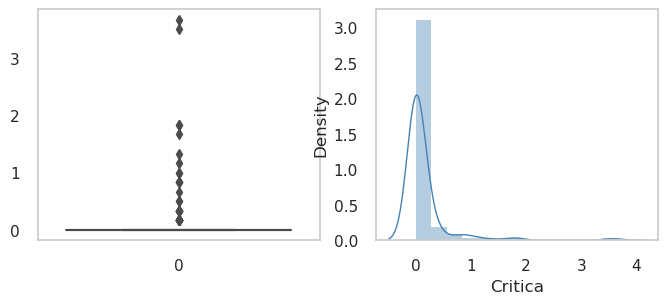

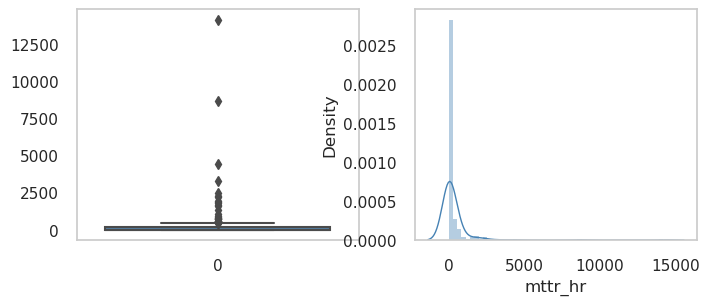

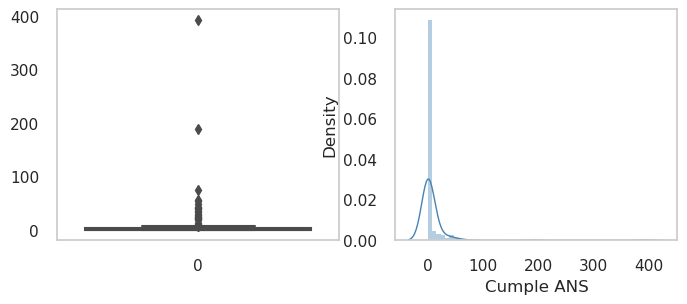

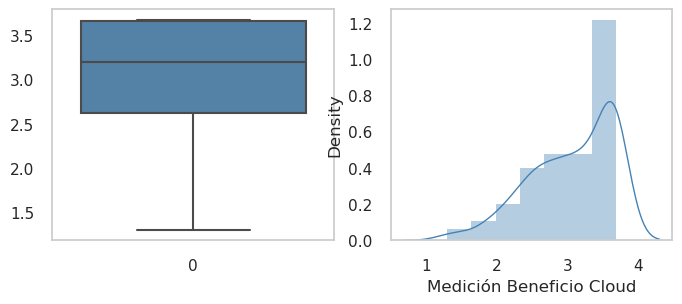

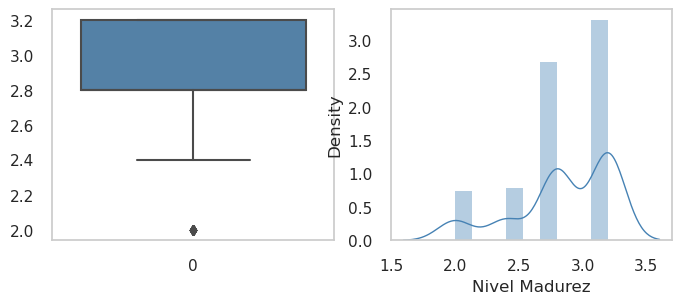

In [124]:
fig_num = 1        
for col in df.select_dtypes(include=[np.number]).columns:
    if col in columnas:
        hist_box_plot(df,col, fig_num)
        fig_num = fig_num + 1

Esto nos proporciona información como la media, mediana, rango intercuartil identificando los valores atipicos para cada de las variables, decidimos implementar la estrategia de reemplazo de outliers, llevando lo valores atípicos a el límite inferior y superior por EVC para variables númerica

## Manejo de outliers

In [125]:
df_replace_ouliers = pd.DataFrame()

In [126]:
for evc_value in df['Nombre de EVC'].unique():
    filtered_df = df[df['Nombre de EVC'] == evc_value]
    filtered_df_2 = replace_outliers(filtered_df)
    df_replace_ouliers = pd.concat([df_replace_ouliers, filtered_df_2], axis=0)

In [127]:
df_replace_ouliers.shape

(191, 40)

In [128]:
df_replace_ouliers.describe()

,"¿Cómo valoras tu satisfacción al usar las capacidades del MO TI en tu día a día; las consideras sencillas, te brindan autonomía y te generan valor?",%Disponibilidad,Min Afectación,Baja,Media,Critica,mttr_hr,Cumple ANS,LT,PT,...,Sentimiento de temor o ansiedad por los cambios que traerá esta transformación,No existe cultura de medición,El cambio no tiene la suficiente credibilidad al momento de generar resultados,El modelo de toma de decisiones para este cambio no es claro,Existen barreras de comunicación en la organización que afectan este cambio,Los objetivos que busca este cambio no están alineados con los objetivos de la organización,Ubicacion Infra,Beneficio Cloud,Medición Beneficio Cloud,Nivel Madurez
count,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,...,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000
mean,8.159031,0.987686,176.043194,3.108966,0.128163,0.078970,161.208846,3.406414,63.694844,28.516881,...,0.243455,0.267016,0.397906,0.242147,0.382199,0.281414,2.784031,2.208115,3.068924,2.883246
std,0.726713,0.051674,296.606735,8.568713,0.462804,0.326966,348.671484,8.809911,38.744194,42.382413,...,0.648092,0.568387,0.928380,0.651242,0.861759,0.814039,0.885642,0.820810,0.583464,0.328324
min,6.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,7.744855,0.000010,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.298300,2.000000
25%,8.000000,0.991689,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,39.593719,10.095732,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,2.627149,2.800000
50%,8.000000,0.997743,52.500000,0.166667,0.000000,0.000000,5.132407,0.333333,54.263828,16.916107,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,3.199358,2.800000
75%,8.562500,1.000000,215.333333,2.166667,0.000000,0.000000,150.829945,2.750000,84.120487,28.452575,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,3.666000,3.200000
max,10.000000,1.000000,1689.833333,72.333333,3.125000,3.666667,2209.425741,74.333333,321.353678,373.365183,...,2.000000,2.000000,3.000000,4.000000,4.000000,3.000000,4.000000,3.000000,3.679435,3.200000


Analizamos la información luego de aplicar está estrategia y mejor comportamiento de las variables, logrando mantener la estructura de la distribución pero reduciendo la influencia de los valores extremos

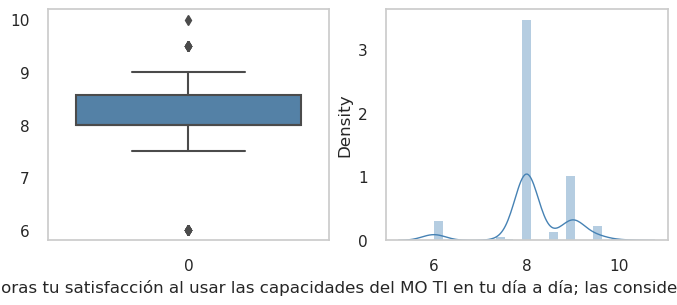

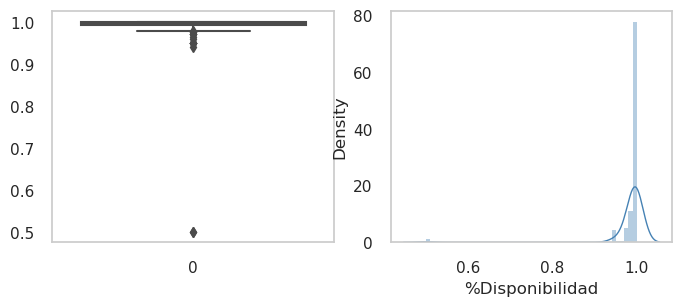

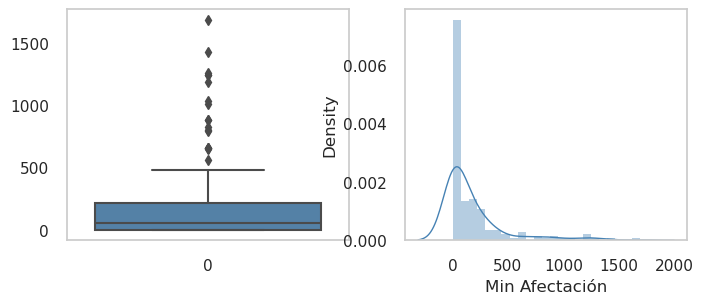

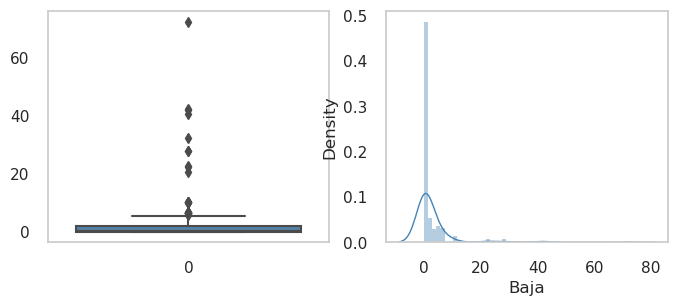

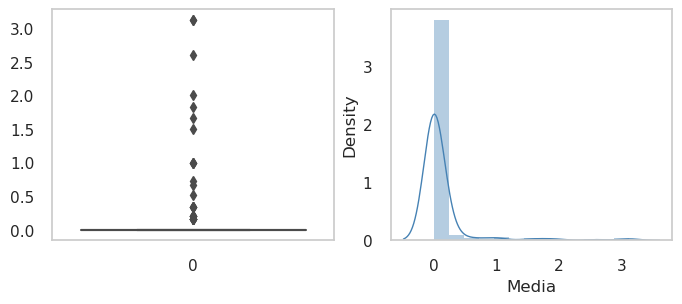

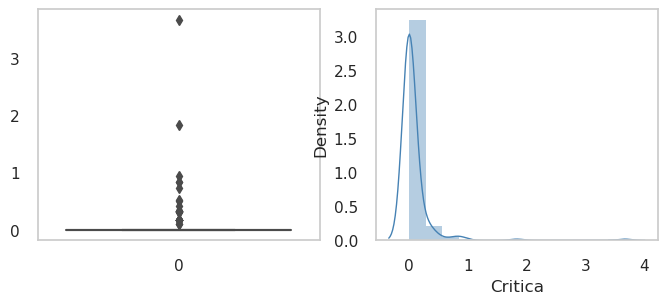

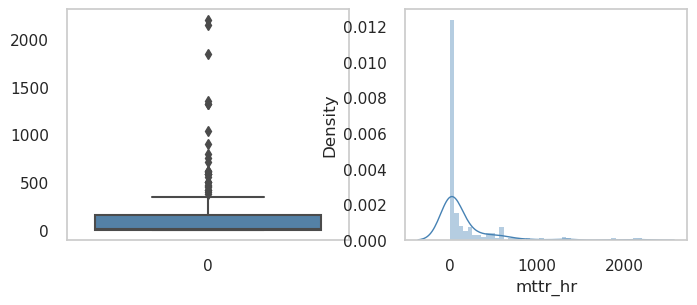

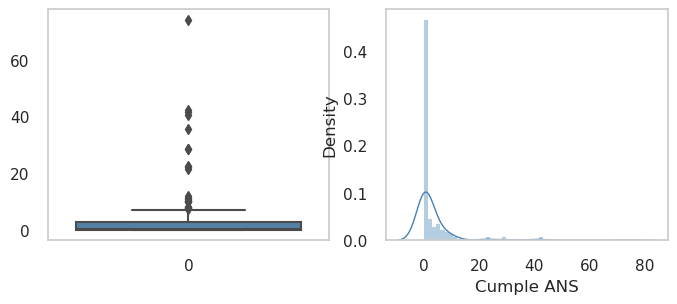

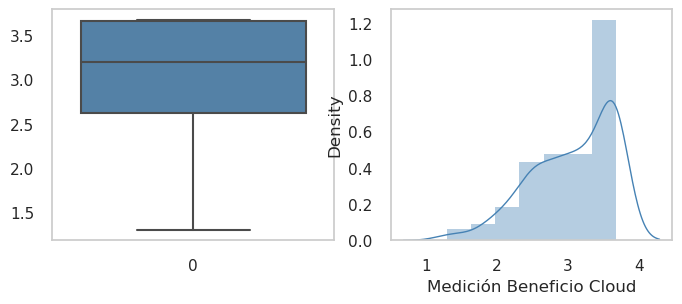

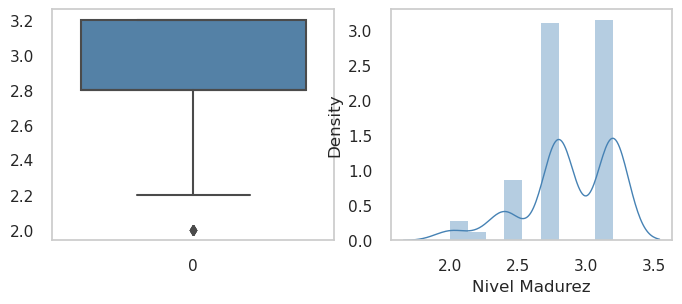

In [129]:
fig_num = 1        
for col in df.select_dtypes(include=[np.number]).columns:
    if col in columnas:
        hist_box_plot(df_replace_ouliers,col, fig_num)
        fig_num = fig_num + 1

Decidimos relizar un modelo para la data original y otro modelo para la data con el reemplazo de outliers

# Modelo HDBS Original

## Estandarizar variables

In [130]:
data_scale = df.copy()
# scaler = PowerTransformer(method='yeo-johnson', standardize=True)
data_scale.iloc[:, 1:]= preprocessing.MinMaxScaler().fit_transform(data_scale.iloc[:, 1:])
# data_scale.iloc[:, 1:]= scaler.fit_transform(data_scale.iloc[:, 1:])

In [131]:
data_scale.head()

,cod app,"¿Cómo valoras tu satisfacción al usar las capacidades del MO TI en tu día a día; las consideras sencillas, te brindan autonomía y te generan valor?",%Disponibilidad,Min Afectación,Baja,Media,Critica,mttr_hr,Cumple ANS,LT,...,Sentimiento de temor o ansiedad por los cambios que traerá esta transformación,No existe cultura de medición,El cambio no tiene la suficiente credibilidad al momento de generar resultados,El modelo de toma de decisiones para este cambio no es claro,Existen barreras de comunicación en la organización que afectan este cambio,Los objetivos que busca este cambio no están alineados con los objetivos de la organización,Ubicacion Infra,Beneficio Cloud,Medición Beneficio Cloud,Nivel Madurez
0,NU0364001,0.5,0.995152,0.098925,0.000852,0.000000,0.090909,0.004740,0.001694,0.178518,...,0.0,0.0,0.000000,0.0,0.00,0.0,0.75,0.666667,0.920829,0.666667
1,AW0450001,0.5,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072958,...,0.0,0.0,0.000000,0.0,0.00,0.0,0.75,1.000000,0.807947,1.000000
2,AW1152001,0.5,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.099919,...,0.0,0.0,0.000000,0.0,0.00,0.0,0.75,0.666667,1.000000,0.666667
3,NU0109001,0.0,0.000000,0.000000,0.115040,0.766667,0.045455,0.161979,0.124524,0.155559,...,0.0,0.5,0.333333,0.0,0.25,0.0,0.75,1.000000,0.500385,1.000000
4,AW1182001,0.5,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.288960,...,0.0,0.0,0.000000,0.0,0.00,0.0,0.75,0.333333,0.669394,0.333333


Iedntificamos previamente que nuestro dataset tiene alta dimensionalidad por tener muchas variables categóricas, decidimos aplicar la técnica de análisis de componente principales (PCA) que permite reducir la dimensionalidad (3 componentes) mientras se mantiene la mayor variabilidad presente en los datos.

In [132]:
n_components = 3  # Número de componentes principales deseados
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(data_scale.iloc[:, 1:])
X_pca = pd.DataFrame(X_pca)
X_pca

,0,1,2
0,-0.151368,-0.131784,0.167600
1,-0.425596,0.419982,-0.487493
2,-0.604280,-0.960614,-0.178071
3,0.238822,0.467713,-1.077319
4,-0.525706,0.573947,-0.295429
...,...,...,...
186,-0.596942,-1.053194,-0.104257
187,-0.476636,0.446195,-0.268370
188,-0.600660,-1.038863,-0.059322
189,-0.612370,-1.042208,-0.056639


In [133]:
data_scale = pd.concat([data_scale[['cod app']],X_pca], axis=1)

In [134]:
data_scale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cod app  191 non-null    object 
 1   0        191 non-null    float64
 2   1        191 non-null    float64
 3   2        191 non-null    float64
dtypes: float64(3), object(1)
memory usage: 6.1+ KB


## Modelo Clustering

Creamos la base de modelado.

In [135]:
# # import pycaret clustering and init setup
s = clustering.setup(
    data=data_scale,
    index='cod app',
    # ignore_features='geometry',
    preprocess=False,
    imputation_type=None,
    remove_multicollinearity=False,
    normalize = False,
    pca=False,
    session_id = 123
)

,Description,Value
0,Session id,123
1,Original data shape,"(191, 3)"
2,Transformed data shape,"(191, 3)"
3,Numeric features,3


## Datos Transformados

In [136]:
data_model = clustering.get_config("X_transformed")
data_model.head()

,0,1,2
cod app,,,
NU0364001,-0.151368,-0.131784,0.167600
AW0450001,-0.425596,0.419982,-0.487493
AW1152001,-0.604280,-0.960614,-0.178071
NU0109001,0.238822,0.467713,-1.077319
AW1182001,-0.525706,0.573947,-0.295429


In [137]:
data_model.shape

(191, 3)

## Hyperparameter Tuning

Se realizó una búsqueda de los mejores hiperparámetros con un análisis de grilla.

### Modelo HDBSCAN

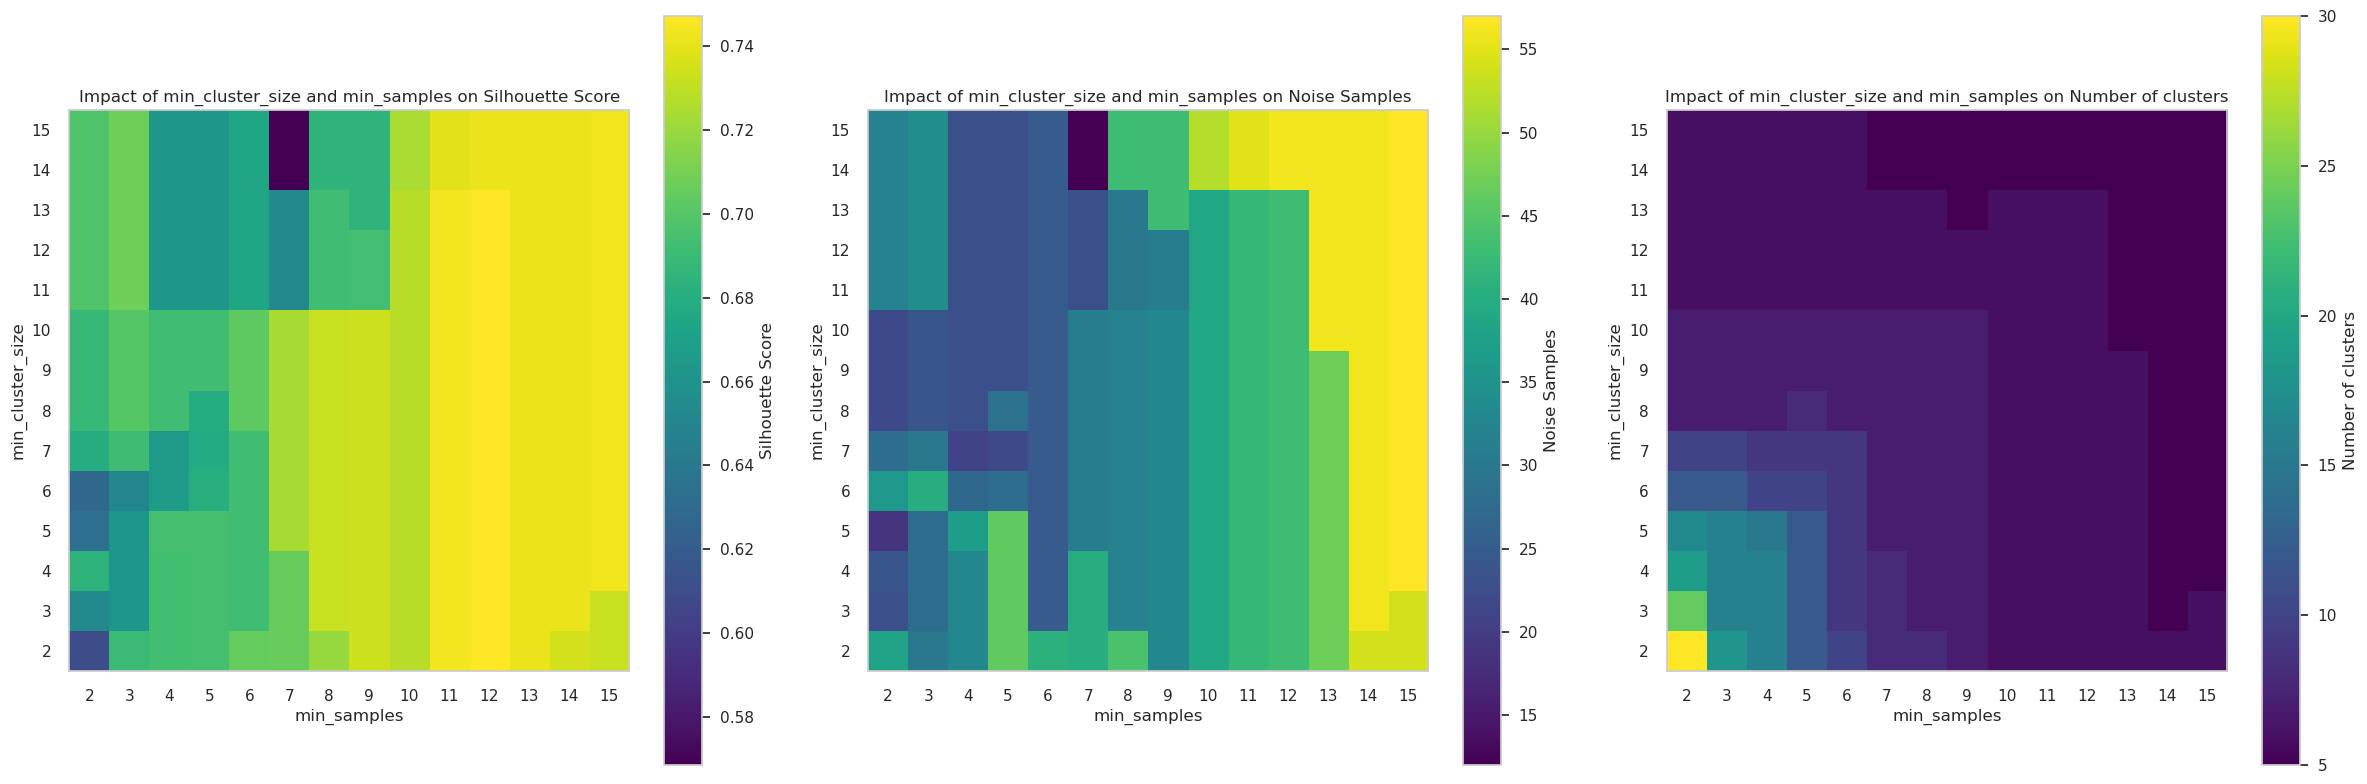

In [138]:
# Define the range of values for min_cluster_size and min_samples
min_cluster_size_range = range(2, 15+1)
min_samples_range = range(2, 15+1)

silhouette_scores = []
noise_scores = []
num_clusters_score = []

# Iterate over the parameter combinations
for min_cluster_size in min_cluster_size_range:
    for min_samples in min_samples_range:
        # Create the HDBSCAN model with the current parameter values
        hdbscan_model = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples
        ).fit(data_model)
        
        # Fit the model
        # clustering_model = clustering.assign_model(hdbscan_model)
        labels = hdbscan_model.labels_
        
        # Get the Silhouette score
        silhouette = silhouette_score(clustering.get_config("X_transformed")[labels != -1], labels[labels != -1])
        
        # Append the Silhouette score to the list
        silhouette_scores.append(silhouette)
        
        noise_scores.append(labels[labels == -1].size)
        num_clusters_score.append(np.unique(labels).size)

# Reshape the scores into a 2D array
silhouette_scores = np.array(silhouette_scores).reshape(len(min_cluster_size_range), len(min_samples_range))
noise_scores = np.array(noise_scores).reshape(len(min_cluster_size_range), len(min_samples_range))
num_clusters_score = np.array(num_clusters_score).reshape(len(min_cluster_size_range), len(min_samples_range))

# Create a subplot with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot the Silhouette scores
im1 = axes[0].imshow(silhouette_scores, cmap='viridis', origin='lower')
axes[0].set_xlabel('min_samples')
axes[0].set_ylabel('min_cluster_size')
axes[0].set_xticks(range(len(min_samples_range)))
axes[0].set_xticklabels(min_samples_range)
axes[0].set_yticks(range(len(min_cluster_size_range)))
axes[0].set_yticklabels(min_cluster_size_range)
axes[0].set_title('Impact of min_cluster_size and min_samples on Silhouette Score')
fig.colorbar(im1, ax=axes[0], label='Silhouette Score')

# Plot the Noise samples
im2 = axes[1].imshow(noise_scores, cmap='viridis', origin='lower')
axes[1].set_xlabel('min_samples')
axes[1].set_ylabel('min_cluster_size')
axes[1].set_xticks(range(len(min_samples_range)))
axes[1].set_xticklabels(min_samples_range)
axes[1].set_yticks(range(len(min_cluster_size_range)))
axes[1].set_yticklabels(min_cluster_size_range)
axes[1].set_title('Impact of min_cluster_size and min_samples on Noise Samples')
fig.colorbar(im2, ax=axes[1], label='Noise Samples')

# Plot the Number of Clusters
im3 = axes[2].imshow(num_clusters_score, cmap='viridis', origin='lower')
axes[2].set_xlabel('min_samples')
axes[2].set_ylabel('min_cluster_size')
axes[2].set_xticks(range(len(min_samples_range)))
axes[2].set_xticklabels(min_samples_range)
axes[2].set_yticks(range(len(min_cluster_size_range)))
axes[2].set_yticklabels(min_cluster_size_range)
axes[2].set_title('Impact of min_cluster_size and min_samples on Number of clusters')
fig.colorbar(im3, ax=axes[2], label='Number of clusters')

plt.tight_layout()

plt.savefig(f'HDBSCAN_ANALYSIS.png', dpi=400)

plt.show()



### HDBSCAN (min_cluster_size = 15, min_samples = 2)

In [139]:
hdbscan_model = clustering.create_model(
    hdbscan.HDBSCAN(),
    min_cluster_size= 15,
    min_samples= 2
)

clustering.evaluate_model(hdbscan_model)

labels = hdbscan_model.labels_
silhouette_noise = silhouette_score(clustering.get_config("X_transformed"), labels)
silhouette_clusters = silhouette_score(clustering.get_config("X_transformed")[labels != -1], labels[labels != -1])

print('-'*60)
print('Silhouette with Noise Cluster: \t\t' + str(round(silhouette_noise, 3)))
print('-'*60)
print('Silhouette without Noise Cluster: \t' + str(round(silhouette_clusters, 3)))
print('-'*60)


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5340,141.6597,1.3378,0,0,0


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

------------------------------------------------------------
Silhouette with Noise Cluster: 		0.534
------------------------------------------------------------
Silhouette without Noise Cluster: 	0.698
------------------------------------------------------------


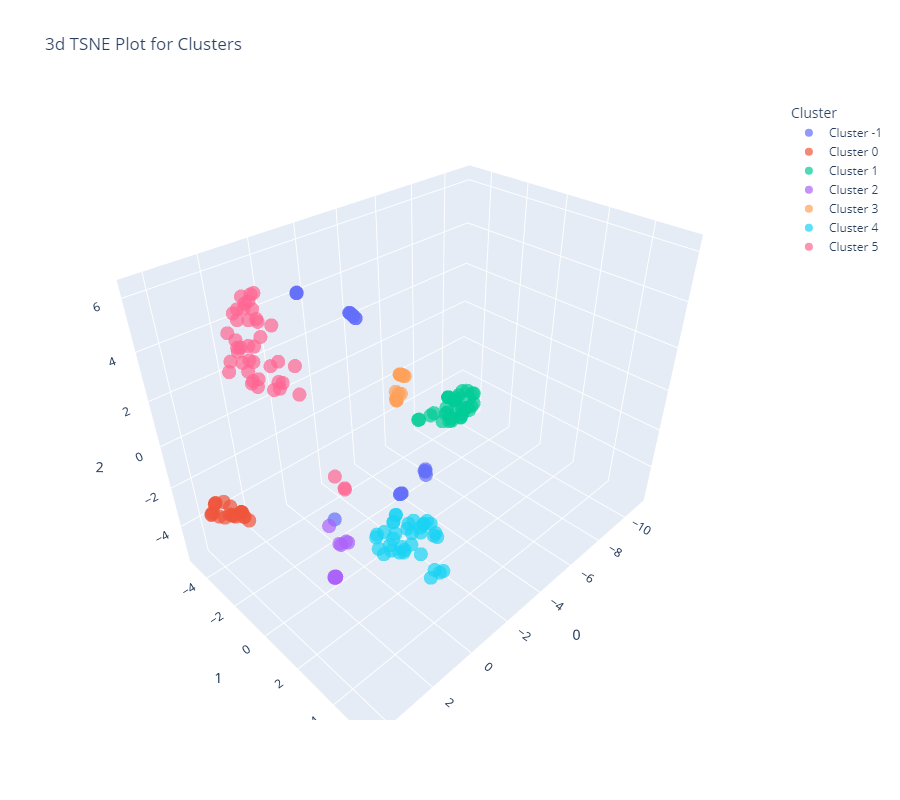

In [140]:
df['Cluster'] = labels

In [141]:
df['Cluster'].value_counts()

 3    41
 4    40
 1    37
-1    32
 0    23
 2    18
Name: Cluster, dtype: int64

In [142]:
df.groupby(['Cluster']).mean()

,"¿Cómo valoras tu satisfacción al usar las capacidades del MO TI en tu día a día; las consideras sencillas, te brindan autonomía y te generan valor?",%Disponibilidad,Min Afectación,Baja,Media,Critica,mttr_hr,Cumple ANS,LT,PT,...,Sentimiento de temor o ansiedad por los cambios que traerá esta transformación,No existe cultura de medición,El cambio no tiene la suficiente credibilidad al momento de generar resultados,El modelo de toma de decisiones para este cambio no es claro,Existen barreras de comunicación en la organización que afectan este cambio,Los objetivos que busca este cambio no están alineados con los objetivos de la organización,Ubicacion Infra,Beneficio Cloud,Medición Beneficio Cloud,Nivel Madurez
Cluster,,,,,,,,,,,,,,,,,,,,,
-1,7.750000,0.963122,251.151042,7.421875,0.786458,0.328125,418.951109,8.536458,84.629018,26.633466,...,0.000000,0.656250,0.406250,0.125000,0.531250,0.000000,2.781250,2.000000,2.954458,2.800000
0,8.652174,0.985891,615.985507,1.608696,0.043478,0.282609,129.537445,1.934783,73.929104,53.581697,...,1.565217,1.347826,2.782609,1.608696,2.478261,2.434783,2.652174,2.478261,2.873512,2.991304
1,8.054054,0.735929,81.968468,2.887387,0.216216,0.103604,286.520864,3.207207,50.648612,29.555752,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.297297,2.108108,3.308549,2.843243
2,8.611111,0.994807,108.666667,13.657407,0.166667,0.101852,529.778636,13.925926,49.609821,9.563316,...,0.666667,0.000000,0.000000,0.333333,0.000000,0.000000,3.055556,1.500000,3.499636,2.600000
3,8.097561,0.992554,127.109756,1.475610,0.117886,0.093496,89.155306,1.686992,76.759932,29.666108,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.975610,2.512195,3.088503,3.004878
4,8.137500,0.997028,93.020833,18.208333,0.212500,0.041667,665.708147,18.462500,75.726971,37.648034,...,0.050000,0.000000,0.000000,0.025000,0.000000,0.000000,2.900000,1.975000,2.804848,2.790000


In [143]:
df_final=df.copy()

# Modelo HDBS reemplazo de outliers por EVC

In [144]:
data_scale = df_replace_ouliers.copy()
data_scale.iloc[:, 1:]= preprocessing.MinMaxScaler().fit_transform(data_scale.iloc[:, 1:])

De igual manera decidimos aplicar la técnica de análisis de componente principales (PCA) a el dataset con reemplazo de ouliers, que permite reducir la dimensionalidad (3 componentes) mientras se mantiene la mayor variabilidad presente en los datos.

In [145]:
n_components = 3  # Número de componentes principales deseados
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(data_scale.iloc[:, 1:])
X_pca = pd.DataFrame(X_pca)
X_pca

,0,1,2
0,-0.139499,-0.190231,0.240554
1,1.965402,0.278237,0.155566
2,0.814753,0.599086,-0.022583
3,1.983752,0.235738,0.176441
4,-0.062756,-0.264299,0.280701
...,...,...,...
186,-0.069552,-0.423878,0.395005
187,-0.065485,-0.419831,0.380979
188,-0.082190,-0.424567,0.388703
189,-0.093828,-0.436851,0.400148


In [146]:
data_scale = pd.concat([data_scale[['cod app']],X_pca], axis=1)

In [147]:
data_scale.head()

,cod app,0,1,2
0,NU0364001,-0.139499,-0.190231,0.240554
20,NU0146001,-0.432388,0.392866,-0.383732
164,AW0360001,-0.623892,0.499027,-0.703921
166,AW0360010,-0.344182,-0.855635,-0.656211
168,NU0214001,-0.215945,-0.204242,0.340969


## Modelo Clustering

Creamos la base de modelado.

In [148]:
# # import pycaret clustering and init setup
s = clustering.setup(
    data=data_scale,
    index='cod app',
    # ignore_features='geometry',
    preprocess=False,
    imputation_type=None,
    remove_multicollinearity=False,
    normalize = False,
    pca=False,
    session_id = 123
)

,Description,Value
0,Session id,123
1,Original data shape,"(191, 3)"
2,Transformed data shape,"(191, 3)"
3,Numeric features,3


## Datos Transformados

In [149]:
data_model2 = clustering.get_config("X_transformed")
data_model2.shape

(191, 3)

## Hyperparameter Tuning

Se decidio probar 3 modelos diferentes, para los cuales se realizo una búqueda de los mejores hiperparámetros con una búsqueda de grilla.

### Modelo HDBSCAN

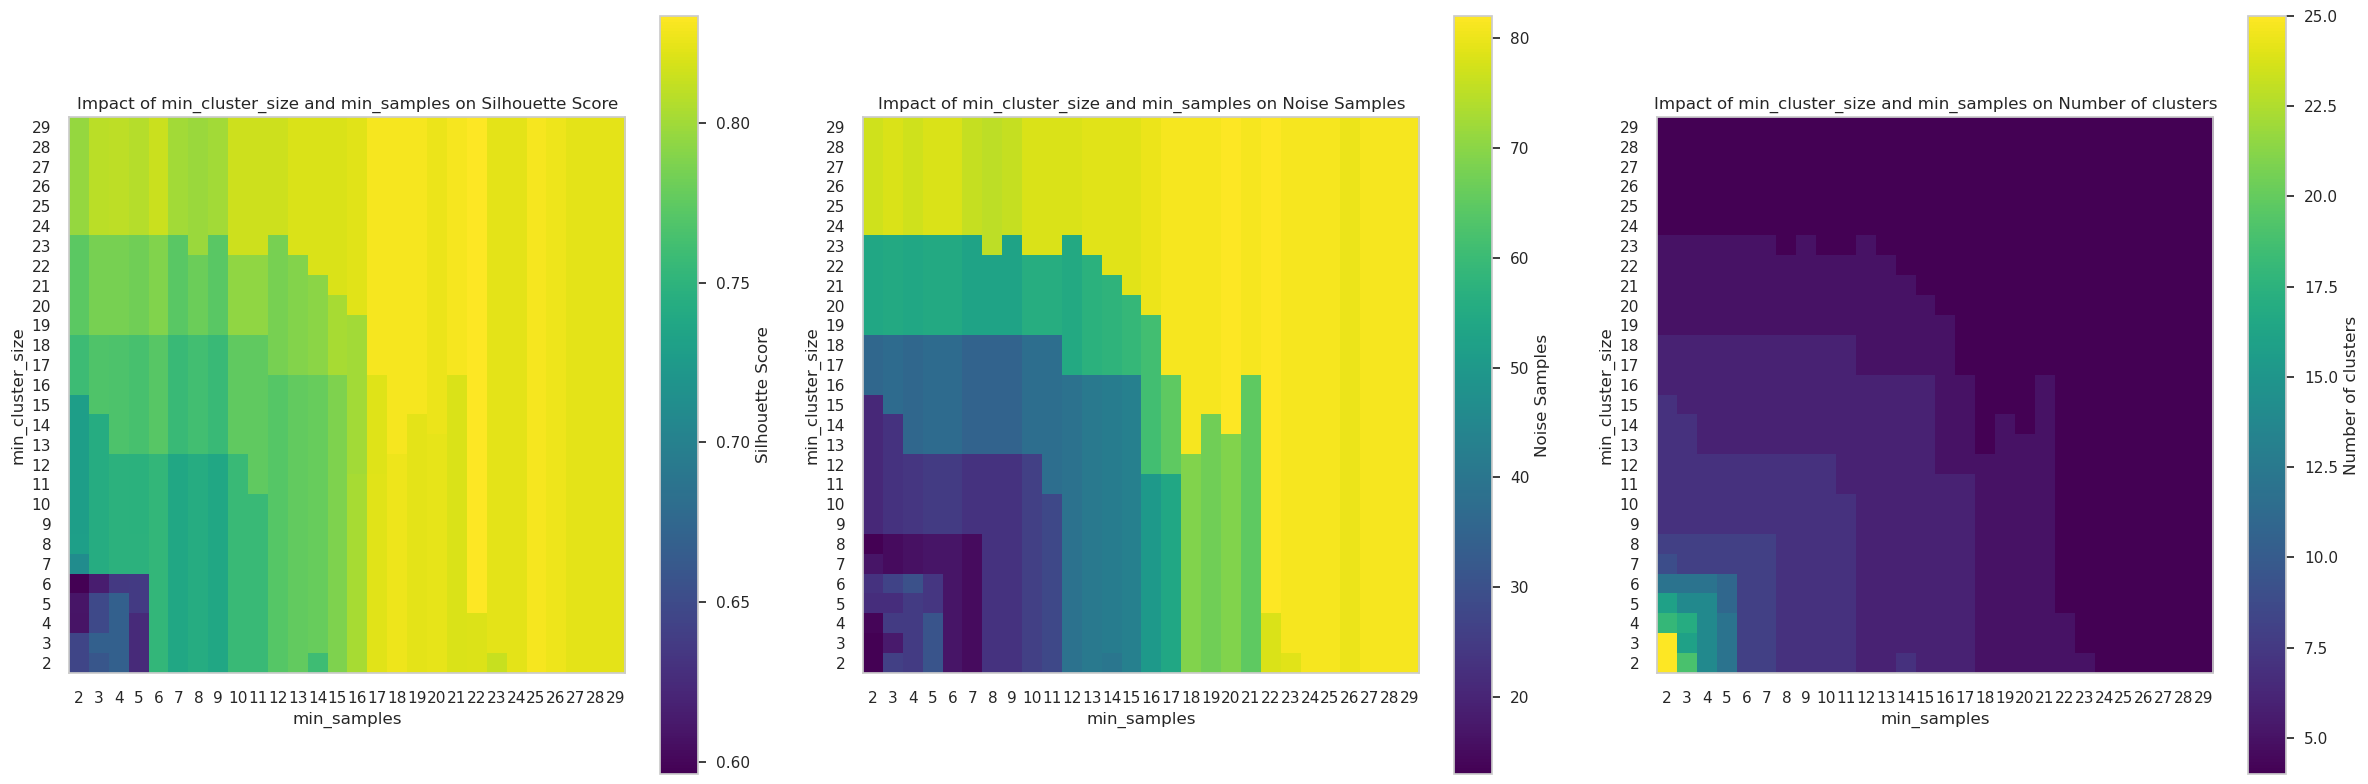

In [150]:
# Define the range of values for min_cluster_size and min_samples
min_cluster_size_range = range(2, 30)
min_samples_range = range(2, 30)

silhouette_scores = []
noise_scores = []
num_clusters_score = []

# Iterate over the parameter combinations
for min_cluster_size in min_cluster_size_range:
    for min_samples in min_samples_range:
        # Create the HDBSCAN model with the current parameter values
        hdbscan_model = hdbscan.HDBSCAN(
            # min_cluster_size=2,
            # min_samples=3
            min_cluster_size=min_cluster_size,
            min_samples=min_samples
        ).fit(data_model2)
        
        # Fit the model
        # clustering_model = clustering.assign_model(hdbscan_model)
        labels = hdbscan_model.labels_
        
        # Get the Silhouette score
        silhouette = silhouette_score(clustering.get_config("X_transformed")[labels != -1], labels[labels != -1])
        
        # Append the Silhouette score to the list
        silhouette_scores.append(silhouette)
        
        noise_scores.append(labels[labels == -1].size)
        num_clusters_score.append(np.unique(labels).size)

# Reshape the scores into a 2D array
silhouette_scores = np.array(silhouette_scores).reshape(len(min_cluster_size_range), len(min_samples_range))
noise_scores = np.array(noise_scores).reshape(len(min_cluster_size_range), len(min_samples_range))
num_clusters_score = np.array(num_clusters_score).reshape(len(min_cluster_size_range), len(min_samples_range))

# Create a subplot with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot the Silhouette scores
im1 = axes[0].imshow(silhouette_scores, cmap='viridis', origin='lower')
axes[0].set_xlabel('min_samples')
axes[0].set_ylabel('min_cluster_size')
axes[0].set_xticks(range(len(min_samples_range)))
axes[0].set_xticklabels(min_samples_range)
axes[0].set_yticks(range(len(min_cluster_size_range)))
axes[0].set_yticklabels(min_cluster_size_range)
axes[0].set_title('Impact of min_cluster_size and min_samples on Silhouette Score')
fig.colorbar(im1, ax=axes[0], label='Silhouette Score')

# Plot the Noise samples
im2 = axes[1].imshow(noise_scores, cmap='viridis', origin='lower')
axes[1].set_xlabel('min_samples')
axes[1].set_ylabel('min_cluster_size')
axes[1].set_xticks(range(len(min_samples_range)))
axes[1].set_xticklabels(min_samples_range)
axes[1].set_yticks(range(len(min_cluster_size_range)))
axes[1].set_yticklabels(min_cluster_size_range)
axes[1].set_title('Impact of min_cluster_size and min_samples on Noise Samples')
fig.colorbar(im2, ax=axes[1], label='Noise Samples')

# Plot the Number of Clusters
im3 = axes[2].imshow(num_clusters_score, cmap='viridis', origin='lower')
axes[2].set_xlabel('min_samples')
axes[2].set_ylabel('min_cluster_size')
axes[2].set_xticks(range(len(min_samples_range)))
axes[2].set_xticklabels(min_samples_range)
axes[2].set_yticks(range(len(min_cluster_size_range)))
axes[2].set_yticklabels(min_cluster_size_range)
axes[2].set_title('Impact of min_cluster_size and min_samples on Number of clusters')
fig.colorbar(im3, ax=axes[2], label='Number of clusters')

plt.tight_layout()

plt.savefig(f'HDBSCAN_ANALYSIS.png', dpi=400)

plt.show()



### HDBSCAN (min_cluster_size = 15, min_samples = 8)

In [151]:
hdbscan_model = clustering.create_model(
    hdbscan.HDBSCAN(),
    min_samples= 8,
    min_cluster_size= 15
    
)

clustering.evaluate_model(hdbscan_model)

labels = hdbscan_model.labels_
silhouette_noise = silhouette_score(clustering.get_config("X_transformed"), labels)
silhouette_clusters = silhouette_score(clustering.get_config("X_transformed")[labels != -1], labels[labels != -1])

print('-'*60)
print('Silhouette with Noise Cluster: \t\t' + str(round(silhouette_noise, 3)))
print('-'*60)
print('Silhouette without Noise Cluster: \t' + str(round(silhouette_clusters, 3)))
print('-'*60)


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5667,132.4729,1.2952,0,0,0


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

------------------------------------------------------------
Silhouette with Noise Cluster: 		0.567
------------------------------------------------------------
Silhouette without Noise Cluster: 	0.762
------------------------------------------------------------


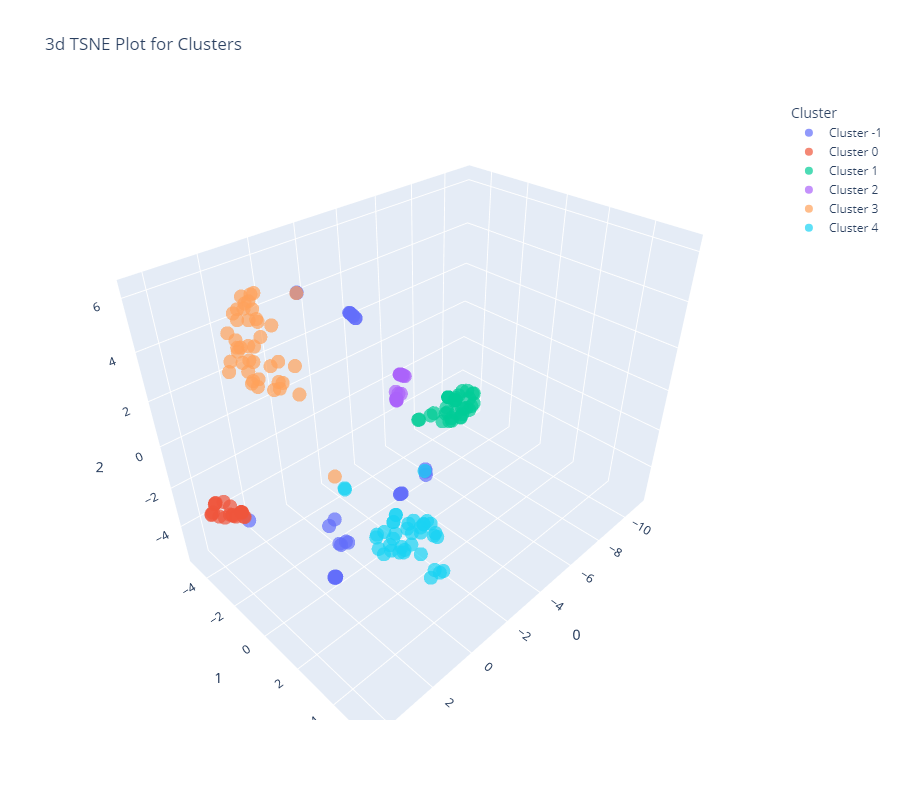

In [152]:
df['Cluster'] = labels

In [153]:
df['Cluster'].value_counts()

 3    42
 4    39
 1    35
-1    35
 0    22
 2    18
Name: Cluster, dtype: int64

In [154]:
df.groupby(['Cluster']).mean()

,"¿Cómo valoras tu satisfacción al usar las capacidades del MO TI en tu día a día; las consideras sencillas, te brindan autonomía y te generan valor?",%Disponibilidad,Min Afectación,Baja,Media,Critica,mttr_hr,Cumple ANS,LT,PT,...,Sentimiento de temor o ansiedad por los cambios que traerá esta transformación,No existe cultura de medición,El cambio no tiene la suficiente credibilidad al momento de generar resultados,El modelo de toma de decisiones para este cambio no es claro,Existen barreras de comunicación en la organización que afectan este cambio,Los objetivos que busca este cambio no están alineados con los objetivos de la organización,Ubicacion Infra,Beneficio Cloud,Medición Beneficio Cloud,Nivel Madurez
Cluster,,,,,,,,,,,,,,,,,,,,,
-1,8.085714,0.905717,136.690476,15.857143,0.176190,0.123810,604.706957,16.157143,68.861840,30.417121,...,0.228571,0.285714,0.314286,0.400000,0.428571,0.171429,2.657143,2.171429,3.053681,2.868571
0,7.886364,0.940607,161.227273,2.795455,0.431818,0.022727,299.891577,3.250000,74.107534,26.120673,...,0.181818,0.181818,0.090909,0.136364,0.136364,0.000000,3.136364,2.318182,3.061638,2.927273
1,8.342857,0.909371,198.023810,5.595238,0.323810,0.080952,266.510033,6.000000,63.378639,41.906189,...,0.228571,0.228571,0.457143,0.171429,0.371429,0.371429,2.828571,2.057143,3.102984,2.822857
2,8.250000,0.993055,253.388889,5.416667,0.296296,0.240741,285.420889,5.953704,80.389518,29.307722,...,0.555556,0.333333,0.777778,0.277778,0.555556,0.666667,3.000000,2.333333,2.871251,2.933333
3,8.035714,0.913253,157.777778,3.527778,0.150794,0.166667,172.205719,3.845238,60.126732,35.744205,...,0.142857,0.285714,0.333333,0.238095,0.380952,0.214286,2.547619,2.190476,3.117998,2.876190
4,8.282051,0.993695,248.102564,9.179487,0.303419,0.235043,444.778257,9.717949,80.015203,24.046615,...,0.358974,0.307692,0.512821,0.256410,0.435897,0.410256,2.717949,1.923077,3.061231,2.769231


# Modelo KMeans

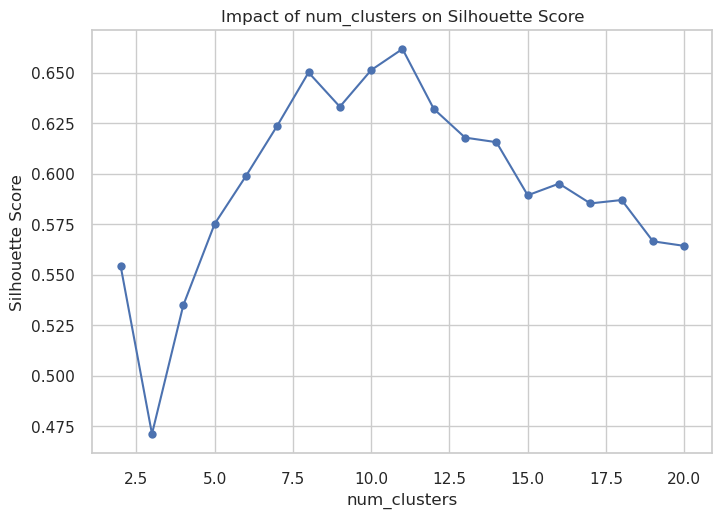

In [155]:
# Define the range of values for num_clusters
num_clusters_range = range(2, 20 + 1)

silhouette_scores = []

# Iterate over the num_clusters values
for num_clusters in num_clusters_range:
    # Create the K-means model with the current num_clusters value
    kmeans_model = KMeans(
        n_clusters=num_clusters
    ).fit(data_model)
    
    # Fit the model
    labels = kmeans_model.labels_
    
    # Get the Silhouette score
    silhouette = silhouette_score(data_model, labels)
    
    # Append the Silhouette score to the list
    silhouette_scores.append(silhouette)

# Plot the Silhouette scores
plt.plot(num_clusters_range, silhouette_scores, marker='o')
plt.xlabel('num_clusters')
plt.ylabel('Silhouette Score')
plt.title('Impact of num_clusters on Silhouette Score')
plt.grid(True)

plt.savefig(f'KMEANS_ANALYSIS.png', dpi=400)
plt.show()

### Kmeans (k=5)

In [156]:
kmeans_model = clustering.create_model(
    'kmeans',
    num_clusters=5
)

clustering.evaluate_model(kmeans_model)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6115,263.6656,0.6032,0,0,0


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

**REVISAR IMAGEN NOMBRE EN REPOSITORIO**

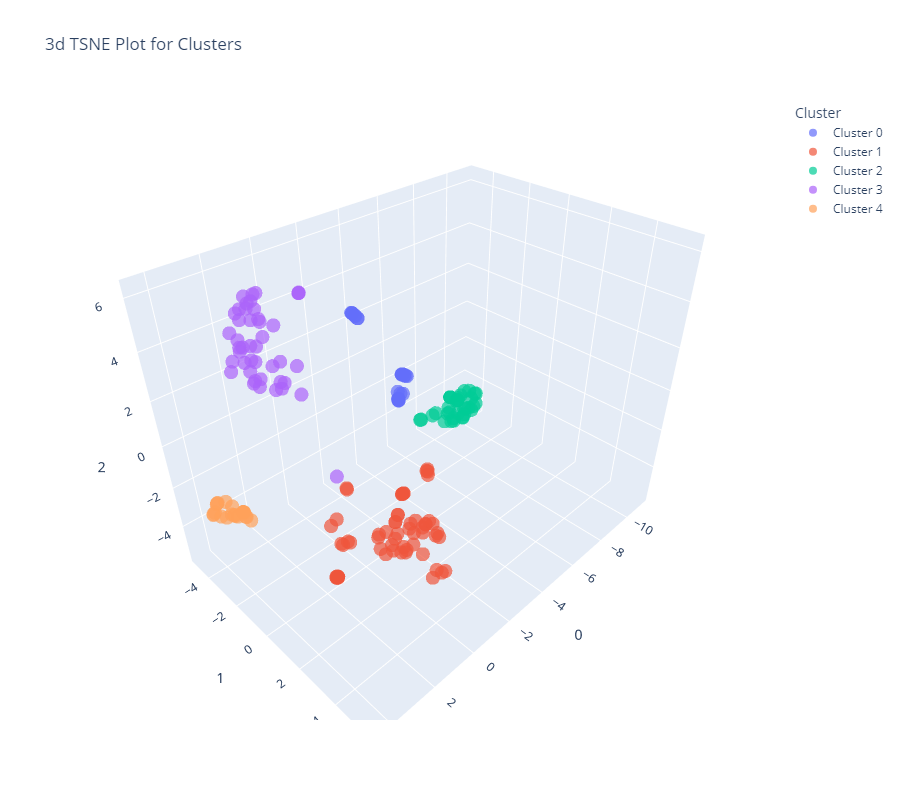

In [157]:
clustering.plot_model(hdbscan_model, plot = 'cluster')

# Elección del modelo

Se decide escoger el modelo de HDBSCAN con data Original, por que cda código app sólo hay un registro y así conservamos el dato original, y la métrica del coeficiente de silueta del 69% nos indica que nuestros clusters están bien separados entre ellos y los registros están muy bien asignados a su respectivo cluster, adicional se tiene un cluster con poco registros de ruído lo cual no afecta negativamente la homogeneidad de los cluster.

## Generar archivo csv

In [158]:
df.head()

,cod app,"¿Cómo valoras tu satisfacción al usar las capacidades del MO TI en tu día a día; las consideras sencillas, te brindan autonomía y te generan valor?",%Disponibilidad,Min Afectación,Baja,Media,Critica,mttr_hr,Cumple ANS,LT,...,No existe cultura de medición,El cambio no tiene la suficiente credibilidad al momento de generar resultados,El modelo de toma de decisiones para este cambio no es claro,Existen barreras de comunicación en la organización que afectan este cambio,Los objetivos que busca este cambio no están alineados con los objetivos de la organización,Ubicacion Infra,Beneficio Cloud,Medición Beneficio Cloud,Nivel Madurez,Cluster
0,NU0364001,8.0,0.995152,167.166667,0.333333,0.000000,0.333333,67.221898,0.666667,64.646553,...,0,0,0,0,0,3,2,3.490919,2.8,3
1,AW0450001,8.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,31.000000,...,0,0,0,0,0,3,3,3.222131,3.2,4
2,AW1152001,8.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,39.593719,...,0,0,0,0,0,3,2,3.679435,2.8,4
3,NU0109001,6.0,0.000000,0.000000,45.000000,3.833333,0.166667,2297.309398,49.000000,57.328434,...,1,1,0,1,0,3,3,2.489784,3.2,1
4,AW1182001,8.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,99.849337,...,0,0,0,0,0,3,1,2.892218,2.4,3


In [159]:
csv_filename = 'cluster_madurez_MOTI.csv'
folder_name = 'Modelo_analiticio_Medicion_Madurez'
df_final.to_csv(csv_filename)

s3_key = f'{folder_name}/{csv_filename}'

try:
    s3.upload_file(csv_filename, bucket_name, s3_key)
    print(f"{csv_filename} cargado exitosamente en la carpeta {folder_name} en S3.")
except NoCredentialsError:
    print("No se encontraron credenciales de AWS o se han configurado incorrectamente.")

cluster_madurez_MOTI.csv cargado exitosamente en la carpeta Modelo_analiticio_Medicion_Madurez en S3.


## *Caracterización*

In [160]:
df_final

,cod app,"¿Cómo valoras tu satisfacción al usar las capacidades del MO TI en tu día a día; las consideras sencillas, te brindan autonomía y te generan valor?",%Disponibilidad,Min Afectación,Baja,Media,Critica,mttr_hr,Cumple ANS,LT,...,No existe cultura de medición,El cambio no tiene la suficiente credibilidad al momento de generar resultados,El modelo de toma de decisiones para este cambio no es claro,Existen barreras de comunicación en la organización que afectan este cambio,Los objetivos que busca este cambio no están alineados con los objetivos de la organización,Ubicacion Infra,Beneficio Cloud,Medición Beneficio Cloud,Nivel Madurez,Cluster
0,NU0364001,8.0,0.995152,167.166667,0.333333,0.000000,0.333333,67.221898,0.666667,64.646553,...,0,0,0,0,0,3,2,3.490919,2.8,3
1,AW0450001,8.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,31.000000,...,0,0,0,0,0,3,3,3.222131,3.2,4
2,AW1152001,8.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,39.593719,...,0,0,0,0,0,3,2,3.679435,2.8,1
3,NU0109001,6.0,0.000000,0.000000,45.000000,3.833333,0.166667,2297.309398,49.000000,57.328434,...,1,1,0,1,0,3,3,2.489784,3.2,-1
4,AW1182001,8.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,99.849337,...,0,0,0,0,0,3,1,2.892218,2.4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,AW1203001,8.0,0.997928,92.500000,0.166667,0.000000,0.000000,9.023148,0.166667,26.335590,...,0,0,0,0,0,2,2,3.108554,2.8,1
187,AW1197001,8.0,1.000000,0.000000,0.500000,0.000000,0.000000,4.978750,0.500000,99.849337,...,0,0,0,0,0,4,2,2.892218,2.8,4
188,AW0823001,8.0,0.996094,161.833333,3.000000,0.333333,0.000000,274.104630,3.333333,39.593719,...,0,0,0,0,0,3,2,3.679382,2.8,1
189,AW1112001,8.0,1.000000,0.000000,0.333333,0.000000,0.166667,21.267083,0.500000,39.593719,...,0,0,0,0,0,3,2,3.679435,2.8,1


In [161]:
df_final_grupedby= df_final.groupby(['Cluster'])
df_final_describe=df_final_grupedby.describe()
df_final_describe

¿Cómo valoras tu satisfacción al usar las capacidades del MO TI en tu día a día; las consideras sencillas, te brindan autonomía y te generan valor?  \
                                                                                                                                                      count   
Cluster                                                                                                                                                       
-1                                                    32.0                                                                                                    
 0                                                    23.0                                                                                                    
 1                                                    37.0                                                                                                    
 2                                                    18.0                                                                                                    
 3                                                    41.0                                                                                                    
 4                                                    40.0                                                                                                    

                                                        %Disponibilidad  \
             mean       std  min  25%  50%    75%   max           count   
Cluster                                                                   
-1       7.750000  1.414214  6.0  6.0  8.0  9.125   9.5            32.0   
 0       8.652174  0.486985  8.0  8.0  9.0  9.000   9.0            23.0   
 1       8.054054  0.229243  8.0  8.0  8.0  8.000   9.0            37.0   
 2       8.611111  0.501631  8.0  8.0  9.0  9.000   9.0            18.0   
 3       8.097561  0.374492  8.0  8.0  8.0  8.000  10.0            41.0   
 4       8.137500  0.542873  6.0  8.0  8.0  8.125   9.0            40.0   

                   ... Medición Beneficio Cloud           Nivel Madurez  \
             mean  ...                      75%       max         count   
Cluster            ...                                                    
-1       0.963122  ...                 3.394161  3.679435          32.0   
 0       0.985891  ...                 3.224666  3.679435          23.0   
 1       0.735929  ...                 3.679412  3.679435          37.0   
 2       0.994807  ...                 3.679410  3.679418          18.0   
 3       0.992554  ...                 3.636724  3.679435          41.0   
 4       0.997028  ...                 3.256441  3.679435          40.0   

                                                      
             mean       std  min  25%  50%  75%  max  
Cluster                                               
-1       2.800000  0.465590  2.0  2.4  2.8  3.2  3.2  
 0       2.991304  0.359182  2.0  2.8  3.2  3.2  3.2  
 1       2.843243  0.350032  2.0  2.8  2.8  3.2  3.2  
 2       2.600000  0.314362  2.0  2.4  2.4  2.8  3.2  
 3       3.004878  0.359132  2.0  2.8  3.2  3.2  3.2  
 4       2.790000  0.344778  2.0  2.8  2.8  3.2  3.2  

[6 rows x 312 columns]

In [162]:
csv_filename = 'cluster_madurez_MOTI.csv'
folder_name = 'Modelo_analiticio_Medicion_Madurez'
df_final.to_csv(csv_filename)

s3_key = f'{folder_name}/{csv_filename}'

try:
    s3.upload_file(csv_filename, bucket_name, s3_key)
    print(f"{csv_filename} cargado exitosamente en la carpeta {folder_name} en S3.")
except NoCredentialsError:
    print("No se encontraron credenciales de AWS o se han configurado incorrectamente.")

cluster_madurez_MOTI.csv cargado exitosamente en la carpeta Modelo_analiticio_Medicion_Madurez en S3.


In [163]:
df_final_describe.to_csv('df_final_describe')

In [164]:
df_final_describe.reset_index(inplace=True)

In [165]:
pivot_ui(df_final_describe)

In [166]:
df_final_CR=df_final[df_final['Cluster']== -1]
df_final_CR.describe()

,"¿Cómo valoras tu satisfacción al usar las capacidades del MO TI en tu día a día; las consideras sencillas, te brindan autonomía y te generan valor?",%Disponibilidad,Min Afectación,Baja,Media,Critica,mttr_hr,Cumple ANS,LT,PT,...,No existe cultura de medición,El cambio no tiene la suficiente credibilidad al momento de generar resultados,El modelo de toma de decisiones para este cambio no es claro,Existen barreras de comunicación en la organización que afectan este cambio,Los objetivos que busca este cambio no están alineados con los objetivos de la organización,Ubicacion Infra,Beneficio Cloud,Medición Beneficio Cloud,Nivel Madurez,Cluster
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,...,32.000000,32.000000,32.000000,32.000000,32.0,32.000000,32.000000,32.000000,32.00000,32.0
mean,7.750000,0.963122,251.151042,7.421875,0.786458,0.328125,418.951109,8.536458,84.629018,26.633466,...,0.656250,0.406250,0.125000,0.531250,0.0,2.781250,2.000000,2.954458,2.80000,-1.0
std,1.414214,0.175852,344.881275,14.925681,1.530007,0.895513,845.220042,16.529637,63.766460,32.790072,...,0.700662,0.498991,0.336011,0.507007,0.0,1.039056,1.163975,0.565173,0.46559,0.0
min,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,34.780033,0.000010,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.491372,2.00000,-1.0
25%,6.000000,0.989511,5.625000,0.000000,0.000000,0.000000,0.000010,0.000000,56.366462,11.905431,...,0.000000,0.000000,0.000000,0.000000,0.0,2.000000,1.000000,2.612632,2.40000,-1.0
50%,8.000000,0.995917,190.916667,0.416667,0.000000,0.000000,15.515463,0.500000,65.212144,18.482511,...,1.000000,0.000000,0.000000,1.000000,0.0,3.000000,2.000000,2.967050,2.80000,-1.0
75%,9.125000,0.999200,290.791667,4.458333,0.750000,0.166667,268.018762,6.083333,76.906954,29.156880,...,1.000000,1.000000,0.000000,1.000000,0.0,3.250000,3.000000,3.394161,3.20000,-1.0
max,9.500000,1.000000,1689.833333,50.666667,5.000000,3.666667,3265.634259,56.000000,322.257950,180.083850,...,2.000000,1.000000,1.000000,1.000000,0.0,4.000000,3.000000,3.679435,3.20000,-1.0


In [167]:
df_final_C0=df_final[df_final['Cluster']== 0]
df_final_C0.describe()

,"¿Cómo valoras tu satisfacción al usar las capacidades del MO TI en tu día a día; las consideras sencillas, te brindan autonomía y te generan valor?",%Disponibilidad,Min Afectación,Baja,Media,Critica,mttr_hr,Cumple ANS,LT,PT,...,No existe cultura de medición,El cambio no tiene la suficiente credibilidad al momento de generar resultados,El modelo de toma de decisiones para este cambio no es claro,Existen barreras de comunicación en la organización que afectan este cambio,Los objetivos que busca este cambio no están alineados con los objetivos de la organización,Ubicacion Infra,Beneficio Cloud,Medición Beneficio Cloud,Nivel Madurez,Cluster
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,...,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.0
mean,8.652174,0.985891,615.985507,1.608696,0.043478,0.282609,129.537445,1.934783,73.929104,53.581697,...,1.347826,2.782609,1.608696,2.478261,2.434783,2.652174,2.478261,2.873512,2.991304,0.0
std,0.486985,0.012376,504.055652,2.746719,0.103199,0.551478,249.868170,3.037534,69.244883,74.766068,...,0.486985,0.421741,1.033051,0.730477,0.843482,1.027295,0.897956,0.488382,0.359182,0.0
min,8.000000,0.958741,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,23.518229,5.372312,...,1.000000,2.000000,1.000000,2.000000,1.000000,0.000000,0.000000,1.932847,2.000000,0.0
25%,8.000000,0.979326,31.500000,0.000000,0.000000,0.000000,0.000010,0.000000,42.879224,20.484798,...,1.000000,3.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.596940,2.800000,0.0
50%,9.000000,0.986813,653.166667,0.000000,0.000000,0.000000,0.000010,0.000000,48.368081,29.409130,...,1.000000,3.000000,1.000000,2.000000,3.000000,3.000000,3.000000,2.926697,3.200000,0.0
75%,9.000000,0.999294,1024.833333,2.083333,0.000000,0.250000,86.215231,2.916667,76.867054,55.900963,...,2.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.224666,3.200000,0.0
max,9.000000,1.000000,1430.833333,10.333333,0.333333,1.833333,905.320417,10.333333,326.490125,373.365183,...,2.000000,3.000000,4.000000,4.000000,3.000000,4.000000,3.000000,3.679435,3.200000,0.0


In [168]:
df_final_C1=df_final[df_final['Cluster']== 1]
df_final_C1.describe()

,"¿Cómo valoras tu satisfacción al usar las capacidades del MO TI en tu día a día; las consideras sencillas, te brindan autonomía y te generan valor?",%Disponibilidad,Min Afectación,Baja,Media,Critica,mttr_hr,Cumple ANS,LT,PT,...,No existe cultura de medición,El cambio no tiene la suficiente credibilidad al momento de generar resultados,El modelo de toma de decisiones para este cambio no es claro,Existen barreras de comunicación en la organización que afectan este cambio,Los objetivos que busca este cambio no están alineados con los objetivos de la organización,Ubicacion Infra,Beneficio Cloud,Medición Beneficio Cloud,Nivel Madurez,Cluster
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,...,37.0,37.0,37.0,37.0,37.0,37.000000,37.000000,37.000000,37.000000,37.0
mean,8.054054,0.735929,81.968468,2.887387,0.216216,0.103604,286.520864,3.207207,50.648612,29.555752,...,0.0,0.0,0.0,0.0,0.0,2.297297,2.108108,3.308549,2.843243,1.0
std,0.229243,0.420505,170.456177,7.456050,0.714559,0.319991,808.259515,7.647359,34.826450,59.098036,...,0.0,0.0,0.0,0.0,0.0,1.288084,0.875080,0.544221,0.350032,0.0
min,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,15.087644,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.712900,2.000000,1.0
25%,8.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,39.593719,14.833333,...,0.0,0.0,0.0,0.0,0.0,2.000000,2.000000,3.038605,2.800000,1.0
50%,8.000000,0.996034,0.000000,0.166667,0.000000,0.000000,8.437731,0.166667,39.593719,14.903006,...,0.0,0.0,0.0,0.0,0.0,3.000000,2.000000,3.666000,2.800000,1.0
75%,8.000000,1.000000,88.333333,2.000000,0.000000,0.000000,180.231481,2.500000,47.300702,20.088564,...,0.0,0.0,0.0,0.0,0.0,3.000000,3.000000,3.679412,3.200000,1.0
max,9.000000,1.000000,725.000000,38.833333,3.500000,1.666667,4421.278843,39.500000,180.084088,358.640376,...,0.0,0.0,0.0,0.0,0.0,4.000000,3.000000,3.679435,3.200000,1.0


In [169]:
df_final_C2=df_final[df_final['Cluster']== 2]
df_final_C2.describe()

,"¿Cómo valoras tu satisfacción al usar las capacidades del MO TI en tu día a día; las consideras sencillas, te brindan autonomía y te generan valor?",%Disponibilidad,Min Afectación,Baja,Media,Critica,mttr_hr,Cumple ANS,LT,PT,...,No existe cultura de medición,El cambio no tiene la suficiente credibilidad al momento de generar resultados,El modelo de toma de decisiones para este cambio no es claro,Existen barreras de comunicación en la organización que afectan este cambio,Los objetivos que busca este cambio no están alineados con los objetivos de la organización,Ubicacion Infra,Beneficio Cloud,Medición Beneficio Cloud,Nivel Madurez,Cluster
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,...,18.0,18.0,18.000000,18.0,18.0,18.000000,18.000000,18.000000,18.000000,18.0
mean,8.611111,0.994807,108.666667,13.657407,0.166667,0.101852,529.778636,13.925926,49.609821,9.563316,...,0.0,0.0,0.333333,0.0,0.0,3.055556,1.500000,3.499636,2.600000,2.0
std,0.501631,0.008921,119.204073,43.646286,0.563022,0.313836,2033.052085,44.503735,53.720064,5.462764,...,0.0,0.0,0.485071,0.0,0.0,0.416176,0.785905,0.395050,0.314362,0.0
min,8.000000,0.964662,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,15.317201,0.000010,...,0.0,0.0,0.000000,0.0,0.0,2.000000,0.000000,2.399961,2.000000,2.0
25%,8.000000,0.994681,36.500000,0.041667,0.000000,0.000000,0.201968,0.166667,23.537329,9.370114,...,0.0,0.0,0.000000,0.0,0.0,3.000000,1.000000,3.518364,2.400000,2.0
50%,9.000000,0.998176,55.500000,0.250000,0.000000,0.000000,3.452616,0.333333,23.537329,9.370114,...,0.0,0.0,0.000000,0.0,0.0,3.000000,1.000000,3.679358,2.400000,2.0
75%,9.000000,0.998718,187.833333,0.958333,0.000000,0.000000,60.774572,0.958333,62.381938,9.980668,...,0.0,0.0,1.000000,0.0,0.0,3.000000,2.000000,3.679410,2.800000,2.0
max,9.000000,1.000000,414.166667,185.333333,2.333333,1.333333,8666.410463,189.000000,251.498276,25.143591,...,0.0,0.0,1.000000,0.0,0.0,4.000000,3.000000,3.679418,3.200000,2.0


In [170]:
df_final_C3=df_final[df_final['Cluster']== 3]
df_final_C3.describe()

,"¿Cómo valoras tu satisfacción al usar las capacidades del MO TI en tu día a día; las consideras sencillas, te brindan autonomía y te generan valor?",%Disponibilidad,Min Afectación,Baja,Media,Critica,mttr_hr,Cumple ANS,LT,PT,...,No existe cultura de medición,El cambio no tiene la suficiente credibilidad al momento de generar resultados,El modelo de toma de decisiones para este cambio no es claro,Existen barreras de comunicación en la organización que afectan este cambio,Los objetivos que busca este cambio no están alineados con los objetivos de la organización,Ubicacion Infra,Beneficio Cloud,Medición Beneficio Cloud,Nivel Madurez,Cluster
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,...,41.0,41.0,41.0,41.0,41.0,41.000000,41.000000,41.000000,41.000000,41.0
mean,8.097561,0.992554,127.109756,1.475610,0.117886,0.093496,89.155306,1.686992,76.759932,29.666108,...,0.0,0.0,0.0,0.0,0.0,2.975610,2.512195,3.088503,3.004878,3.0
std,0.374492,0.027283,127.167396,3.825456,0.337976,0.193824,173.609862,3.933686,52.868898,34.177864,...,0.0,0.0,0.0,0.0,0.0,0.851111,0.897829,0.517249,0.359132,0.0
min,8.000000,0.823309,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,16.638542,0.750000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.887887,2.000000,3.0
25%,8.000000,0.994992,21.500000,0.000000,0.000000,0.000000,0.000010,0.000000,39.692190,8.054985,...,0.0,0.0,0.0,0.0,0.0,3.000000,2.000000,2.635808,2.800000,3.0
50%,8.000000,0.998009,68.833333,0.000000,0.000000,0.000000,0.777778,0.166667,58.443663,15.396120,...,0.0,0.0,0.0,0.0,0.0,3.000000,3.000000,3.185763,3.200000,3.0
75%,8.000000,0.999600,213.666667,0.666667,0.000000,0.166667,60.784537,1.000000,94.864792,44.053986,...,0.0,0.0,0.0,0.0,0.0,3.000000,3.000000,3.636724,3.200000,3.0
max,10.000000,1.000000,478.000000,22.333333,1.833333,0.833333,715.205972,22.333333,271.000000,154.964607,...,0.0,0.0,0.0,0.0,0.0,4.000000,3.000000,3.679435,3.200000,3.0


In [171]:
df_final_C4=df_final[df_final['Cluster']== 4]
df_final_C4.describe()

,"¿Cómo valoras tu satisfacción al usar las capacidades del MO TI en tu día a día; las consideras sencillas, te brindan autonomía y te generan valor?",%Disponibilidad,Min Afectación,Baja,Media,Critica,mttr_hr,Cumple ANS,LT,PT,...,No existe cultura de medición,El cambio no tiene la suficiente credibilidad al momento de generar resultados,El modelo de toma de decisiones para este cambio no es claro,Existen barreras de comunicación en la organización que afectan este cambio,Los objetivos que busca este cambio no están alineados con los objetivos de la organización,Ubicacion Infra,Beneficio Cloud,Medición Beneficio Cloud,Nivel Madurez,Cluster
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,...,40.0,40.0,40.000000,40.0,40.0,40.000000,40.000000,40.000000,40.000000,40.0
mean,8.137500,0.997028,93.020833,18.208333,0.212500,0.041667,665.708147,18.462500,75.726971,37.648034,...,0.0,0.0,0.025000,0.0,0.0,2.900000,1.975000,2.804848,2.790000,4.0
std,0.542873,0.005077,159.589097,62.655536,0.561068,0.144953,2259.753767,63.047392,43.681434,56.691965,...,0.0,0.0,0.158114,0.0,0.0,0.841244,0.861945,0.688254,0.344778,0.0
min,6.000000,0.976826,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,7.744855,0.189132,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.298300,2.000000,4.0
25%,8.000000,0.996708,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,34.665773,13.642477,...,0.0,0.0,0.000000,0.0,0.0,3.000000,2.000000,2.313059,2.800000,4.0
50%,8.000000,0.999596,20.333333,0.416667,0.000000,0.000000,25.717083,0.500000,96.942032,22.591132,...,0.0,0.0,0.000000,0.0,0.0,3.000000,2.000000,2.892218,2.800000,4.0
75%,8.125000,1.000000,110.916667,9.375000,0.000000,0.000000,542.719873,9.375000,99.849337,27.312500,...,0.0,0.0,0.000000,0.0,0.0,3.000000,3.000000,3.256441,3.200000,4.0
max,9.000000,1.000000,670.000000,391.166667,2.000000,0.833333,14182.766065,393.500000,244.030480,278.979745,...,0.0,0.0,1.000000,0.0,0.0,4.000000,3.000000,3.679435,3.200000,4.0
